In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nptdms import TdmsFile #Process ramping file

#For building ML models
import keras
import keras.models as models
from keras.layers.core import Dense
from keras import regularizers
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.signal import find_peaks

np.random.seed(1337) # for reproducibility


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using TensorFlow backend.


In [ ]:
def load_sensor(dir_path, sensor, time_range = None):
    
    data = pd.DataFrame(data = {sensor: np.load(dir_path + sensor + ".npy"),
                                "time": np.load(dir_path + "time.npy")})
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    data = data[(data["time"] > start) & (data["time"] < end)]
   
    %reset -f in
    
    return data[sensor]

def load_time_label(dir_path, time_range, window = 2000, step = 10):
    
    time_label =  np.load(dir_path + "time.npy")
    
    start = min(time_label)
    end = max(time_label)
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
    
    
    time_label = time_label[(time_label > start) & (time_label < end)][window-1::step]
    
    %reset -f in
    
    return time_label

#### Mean of abs(signal)
def generate_mean_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).abs().rolling(window=window).mean().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_mean = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_mean

#### SD of signal
def generate_sd_data(dir_path, time_range, window = 2000, step = 10):
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).std().to_numpy()[window-1::step]
    
    #Calculate the product
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_sd = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_sd

#### Thresholded zero crossings
def zero_crossings(array):
    
    #Set values outside of range (0.001, 0.1) = 0
    array[abs(array) > 0.1] = 0
    array[abs(array) < 0.005] = 0
    
    #Calculate number of zero-crossing points, normalized by the window size
    zero_crossings = ((array[:-1] * array[1:]) < 0).sum()/array.size
    
    return zero_crossings


def generate_crossings_data(dir_path, time_range = None, window = 5000, step = 10):
    
    #Load the data
    ai0 = load_sensor(dir_path, "ai0", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai1 = load_sensor(dir_path, "ai1", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai2 = load_sensor(dir_path, "ai2", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai3 = load_sensor(dir_path, "ai3", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    ai4 = load_sensor(dir_path, "ai4", time_range = time_range).rolling(window=window).apply(zero_crossings, raw = True).to_numpy()[window-1::step]
    
    product = ai0*ai1*ai2*ai3*ai4
    
    #Stack them together
    all_crossings = np.vstack((ai0,ai1,ai2,ai3,ai4, product)).transpose()
    
    %reset -f in
    
    return all_crossings


def generate_data(dir_path, time_range, window = 2000, thres_win = 25000, step = 10):
    
    #Selection index due to using different window
    selection_index = int((thres_win - window)/step)
    
    moving_mean = generate_mean_data(dir_path, time_range, window = window, step = step)[selection_index:]
    moving_sd = generate_sd_data(dir_path, time_range, window = window, step = step)[selection_index:]
    #moving_thres_crossings = generate_crossings_data(dir_path, time_range, window = thres_win, step = step)
    time_label = load_time_label(dir_path, time_range, window = window, step = step)[selection_index:]
    
    all_data = np.concatenate((moving_mean, moving_sd), axis = 1)
    
    print("All data's shape: ", all_data.shape)
    
    %reset -f in
    
    return all_data, time_label

#####-------INCREMENTAL LEARNING IMPLEMENTATION-------######

def create_model():
    
    #================BUILD THE MODEL====================
    # Simple model
    # Simple model
    model = models.Sequential()

    model.add(Dense(6, activation = 'elu', kernel_initializer='glorot_uniform',
                    kernel_regularizer=regularizers.l2(0.0),
                    input_dim=12))

    model.add(Dense(3,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(6,activation='elu',
                    kernel_initializer='glorot_uniform'))

    model.add(Dense(12,
                    kernel_initializer='glorot_uniform'))

    model.compile(loss='mse',optimizer='adam')


    return model

def train(current_weights, X, time_axis, time_range):
    """Take a model, train it in the appropritate time range, return the new weights
    and its reconstruction loss distribution"""
    
    print("Training for section: ", time_range)
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    X_train = np.copy(X[start_index:end_index])
    time_train = time_axis[start_index:end_index]
    
    #Create model
    model = create_model()
    
    if current_weights:
        model.set_weights(current_weights)
    
    #Scaler initiation
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    
    #Train the model and extract new weights
    model.fit(X_train, X_train,
              batch_size=2000,
              epochs=30, verbose = 0)
    
    new_weights = model.get_weights()
    
    #Evaluate the losses and update the distribution
    X_pred = model.predict(X_train)
    loss = np.mean(np.abs(X_pred-X_train), axis = 1)
    
    #Plot the reconstruction loss
    plt.figure(figsize=(20,2))
    plt.plot(time_train, loss)
    plt.title("TRAINING reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Take the mean of the log loss and update the mean threshold
    current_median = np.median(np.log10(loss))
    
    print("Finished training, median of the log(loss) is: ", current_median)
    
    return new_weights, current_median, scaler

def trigger(current_weights, X, time_axis, time_range, prev_median, scaler):
    
    print("Triggering for section: ", time_range)
    print("Using this median for triggering:", prev_median)
    
    #Select the appropriate time
    start_index = None
    
    if time_range[0] is not None:
        start_index = np.argmax(time_axis > time_range[0])
    else:
        start_index = 0
    
    if time_range[1] == 0:
        end_index = None
    else:
        end_index = np.argmax(time_axis > time_range[1])
    
    time_test = time_axis[start_index:end_index]
    X_test = np.copy(X[start_index:end_index])
    
    X_test = scaler.transform(X_test) #Scale the current data
    
    #Create model
    model = create_model()
    model.set_weights(current_weights)
        
    #Find the test loss (doing this in parallel for the sake of simulation), but in a practical system
    #Ideally we need to do inference every single data point come in
    X_pred_test = model.predict(X_test)
    test_loss = np.mean(np.abs(X_pred_test-X_test), axis = 1)
    
    
    #Plot the reconstruction loss just to check
    plt.figure(figsize=(20,2))
    plt.plot(time_test, test_loss)
    plt.title("Reconstruction loss on {}".format(time_range))
    plt.xlabel("Time [s]")
    plt.show()
    
    #Quantify how much each data point is far away from the distribution
    log_test_loss = np.log10(test_loss)
    
    #Find the trigger time
    trigger_index = np.argmax(log_test_loss > 1.3)
    
    if  trigger_index != 0:
        #Plot the triggered time
        plt.figure(figsize=(20,2))
        plt.plot(time_test, log_test_loss, color = "firebrick")
        plt.title("Log reconstruction loss on {}".format(time_range))
        plt.xlabel("Time [s]")
        
        #Trigger time
        plt.vlines(time_test[trigger_index], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed", label = "Trigger time")
        plt.legend(loc = "upper left")
        
        
        ### Find trigger times
        peaks, _ = find_peaks(log_test_loss, height=1.3, distance = 5000)
        print("Other trigger time: ", time_test[peaks])
        print("Their log loss values are: ", log_test_loss[peaks])
        
        for i in range(len(peaks)):
            plt.vlines(time_test[peaks[i]], log_test_loss.min(), log_test_loss.max(), color = "blue", linestyles = "dashed")
            
        plt.show()
        
        return list(time_test[peaks])
    
    else:
        return None
    

def simulation(dir_path, section_size, time_range):
    
    #Load data and create the model
    X, time_axis = generate_data(dir_path, time_range = time_range, window = 2000, step = 10)
    
    #For updating model
    current_weights = None
    new_weights = None
    
    #For keeping track of distribution history
    prev_median = None
    updated_median = None
    
    #Keeping track of scaler after training
    past_scaler = None
    
    #Calculate number of sections
    num_section = int(abs(time_range[0])/section_size)
    print("Number of sections:", num_section)
    
    #Keeping log of all the trigger time
    trigger_log = []
    
    #Sequentially go through the data
    for i in range(num_section):
        
        print("Entering sections: ", (-section_size*(num_section - i), -section_size*(num_section - i - 1)))
        print("-------->")
        
        if i == 0:
            continue
        elif i == 1:
            #Train on the first segment
            time_range = (None, -section_size*(num_section - i))
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, time_range)
        else:
            
            #Set previous distrubution to the newly trained disttribution
            prev_median = updated_median
            current_scaler = new_scaler
            current_weights = new_weights
            
            #Selecting appropriate time range for training and triggering
            train_time_range = (-section_size*(num_section - i + 1), -section_size*(num_section - i))
            trigger_time_range = (-section_size*(num_section - i), -section_size*(num_section - i - 1))
            
            #Train and predict simutaneously
            new_weights, updated_median, new_scaler = train(current_weights, X, time_axis, train_time_range)
            trigger_time = trigger(current_weights, X, time_axis, trigger_time_range, prev_median, current_scaler)
            
            if trigger_time is not None:
                print("Triggered at: ", trigger_time)
                trigger_log.extend(trigger_time)
        
        print("<--------")
        
    print("Finished simulation, all the triggered times are: ", trigger_log)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (897500, 12)
Flushing input history
Number of sections: 9
Entering sections:  (-90, -80)
-------->
Entering sections:  (-80, -70)
-------->
Training for section:  (None, -80)


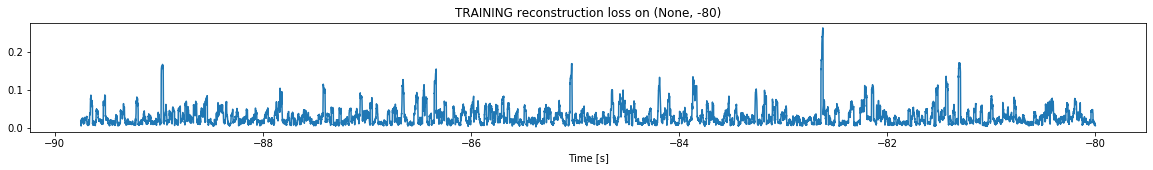

Finished training, median of the log(loss) is:  -1.6503474515364267
<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


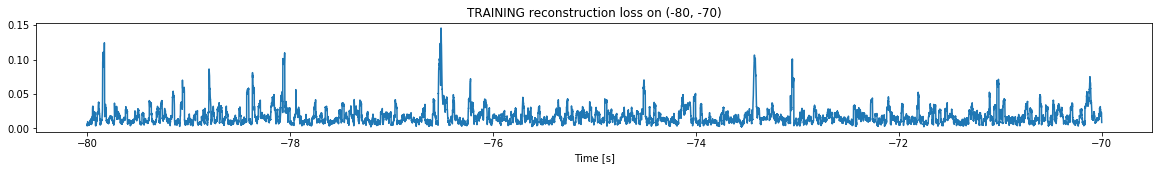

Finished training, median of the log(loss) is:  -1.8469554495340716
Triggering for section:  (-70, -60)
Using this median for triggering: -1.6503474515364267


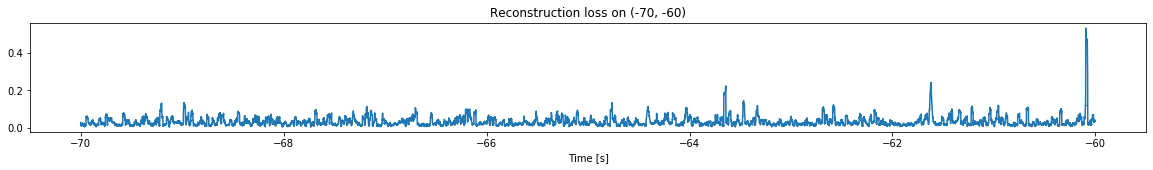

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


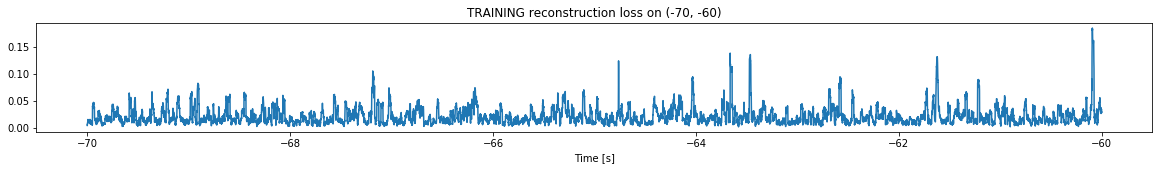

Finished training, median of the log(loss) is:  -1.7508989276908515
Triggering for section:  (-60, -50)
Using this median for triggering: -1.8469554495340716


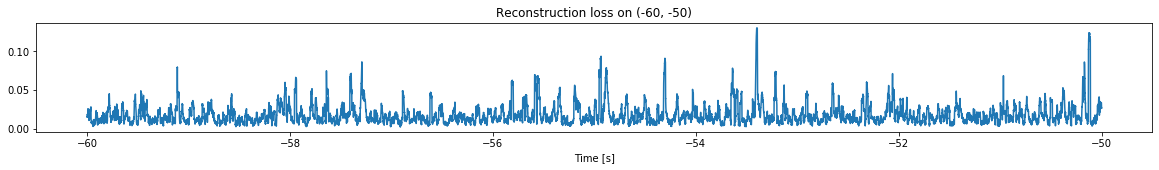

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


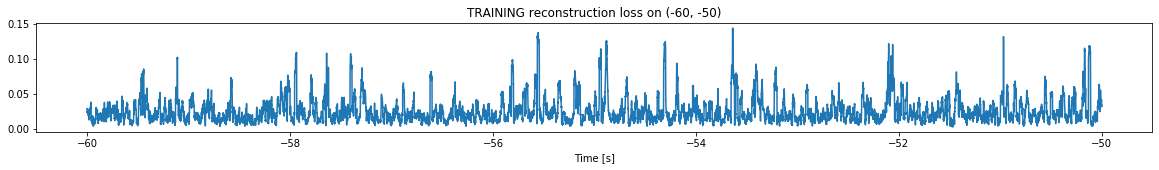

Finished training, median of the log(loss) is:  -1.6880082428517045
Triggering for section:  (-50, -40)
Using this median for triggering: -1.7508989276908515


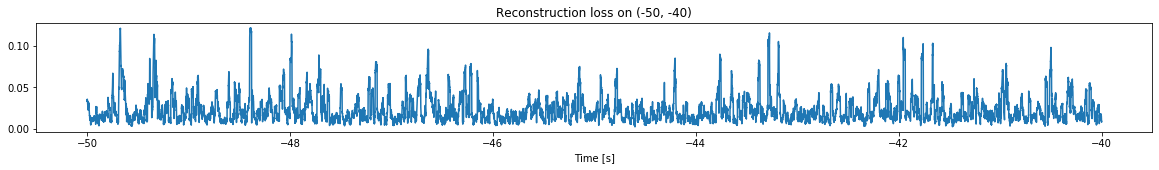

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


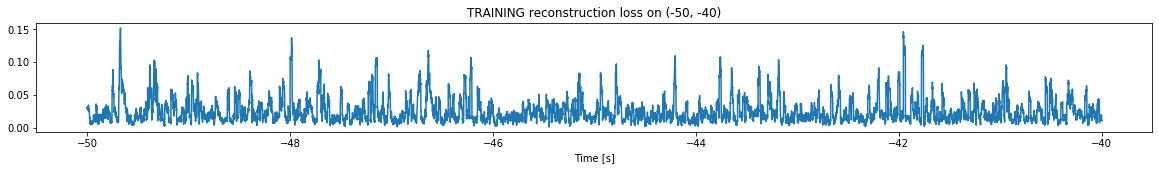

Finished training, median of the log(loss) is:  -1.6961809494499147
Triggering for section:  (-40, -30)
Using this median for triggering: -1.6880082428517045


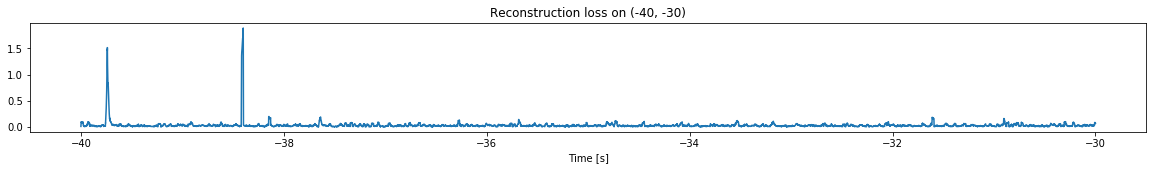

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


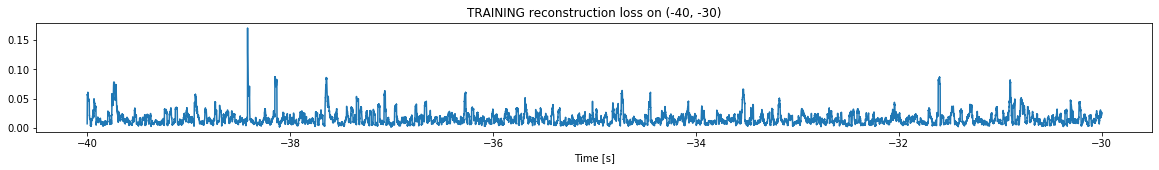

Finished training, median of the log(loss) is:  -1.9049581020657398
Triggering for section:  (-30, -20)
Using this median for triggering: -1.6961809494499147


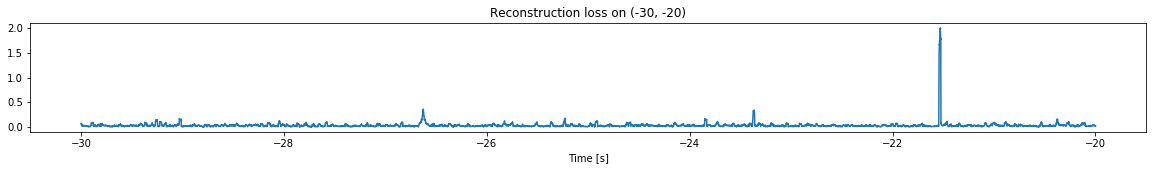

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


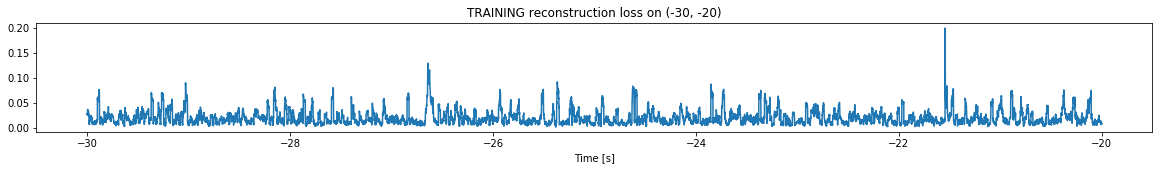

Finished training, median of the log(loss) is:  -1.7767005565510088
Triggering for section:  (-20, -10)
Using this median for triggering: -1.9049581020657398


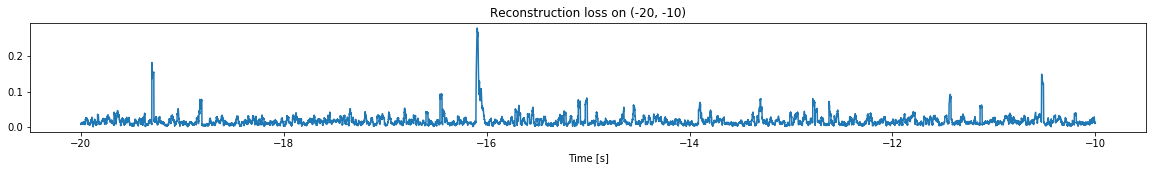

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


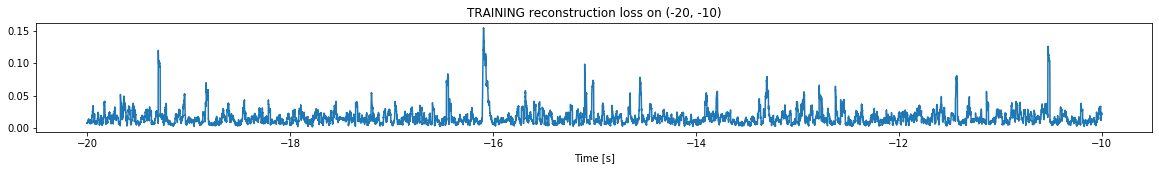

Finished training, median of the log(loss) is:  -1.883524808153659
Triggering for section:  (-10, 0)
Using this median for triggering: -1.7767005565510088


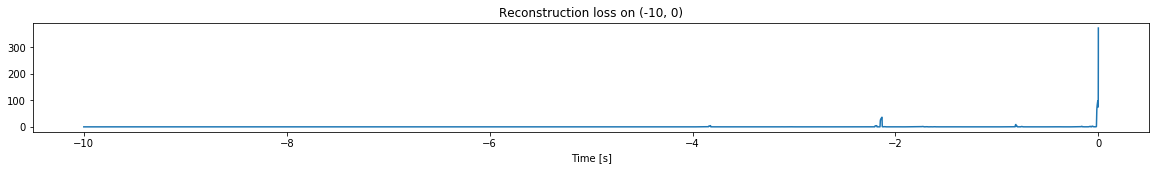

Other trigger time:  [-2.1325998 -0.006    ]
Their log loss values are:  [1.56158179 1.99275315]


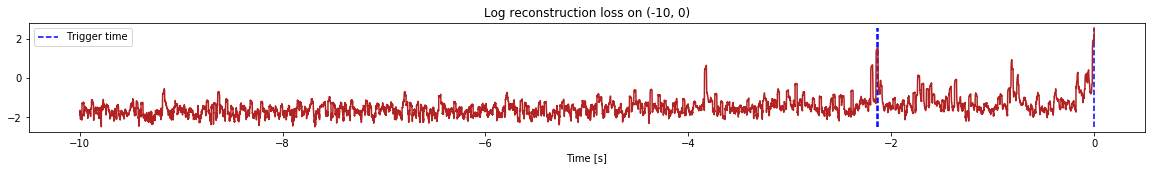

Triggered at:  [-2.1325998, -0.006]
<--------
Finished simulation, all the triggered times are:  [-2.1325998, -0.006]


In [6]:
simulation("./data/Ramp4/", 10, (-90,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (897500, 12)
Flushing input history
Number of sections: 9
Entering sections:  (-90, -80)
-------->
Entering sections:  (-80, -70)
-------->
Training for section:  (None, -80)


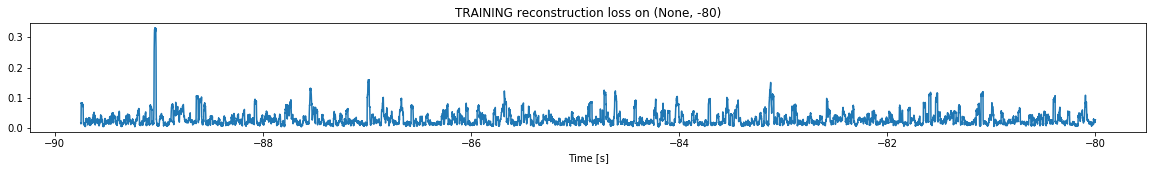

Finished training, median of the log(loss) is:  -1.6529174124528718
<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


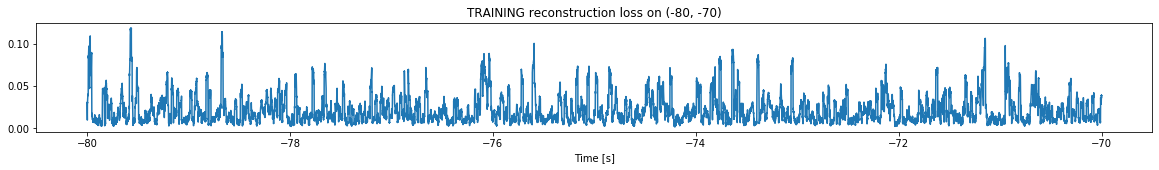

Finished training, median of the log(loss) is:  -1.7699457961127636
Triggering for section:  (-70, -60)
Using this median for triggering: -1.6529174124528718


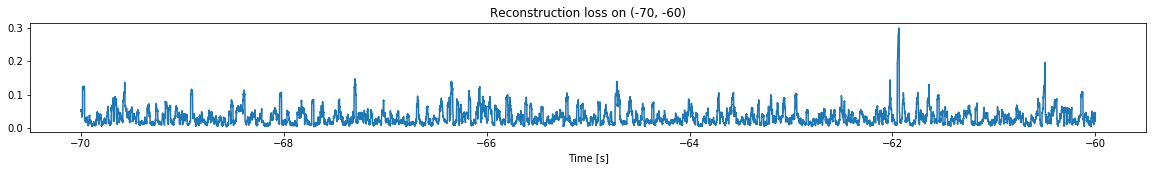

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


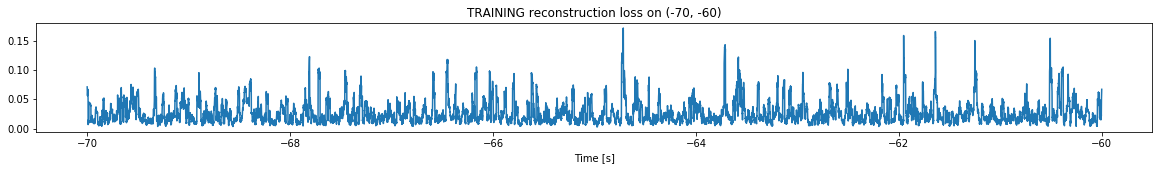

Finished training, median of the log(loss) is:  -1.6754526711704454
Triggering for section:  (-60, -50)
Using this median for triggering: -1.7699457961127636


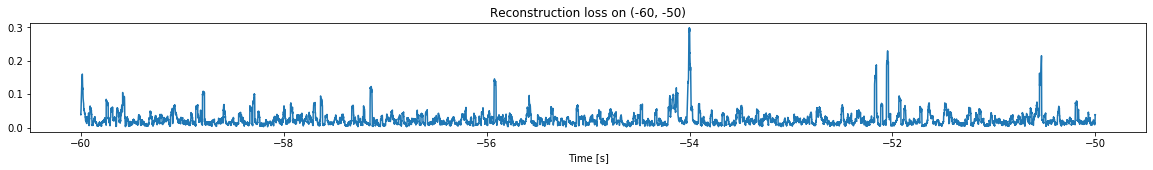

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


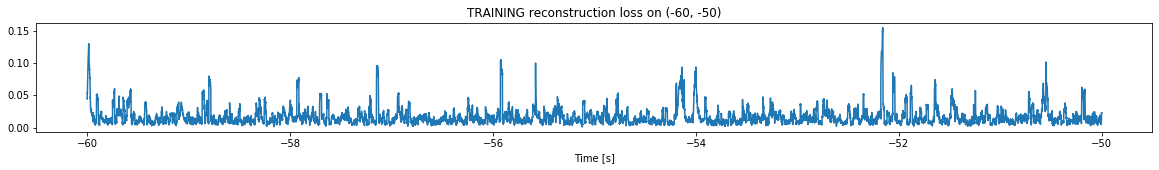

Finished training, median of the log(loss) is:  -1.8832918154902303
Triggering for section:  (-50, -40)
Using this median for triggering: -1.6754526711704454


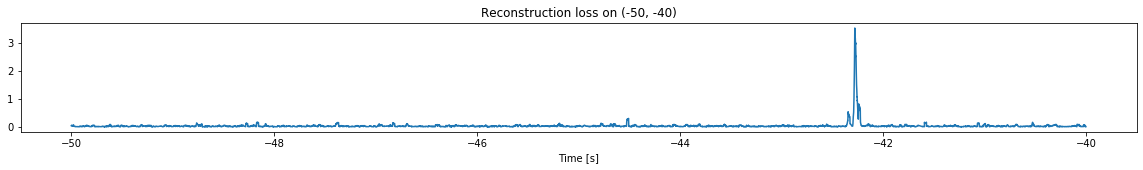

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


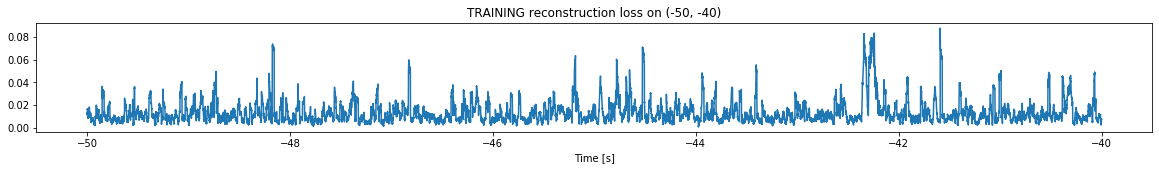

Finished training, median of the log(loss) is:  -1.9668304889245738
Triggering for section:  (-40, -30)
Using this median for triggering: -1.8832918154902303


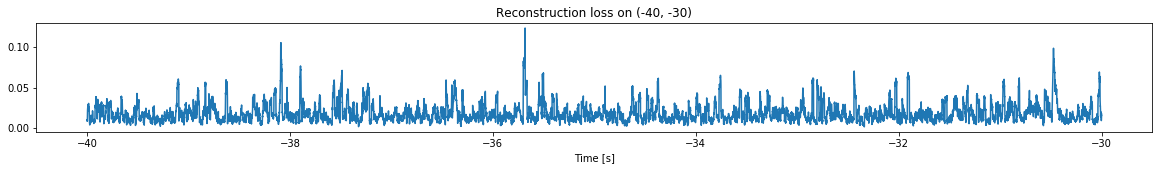

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


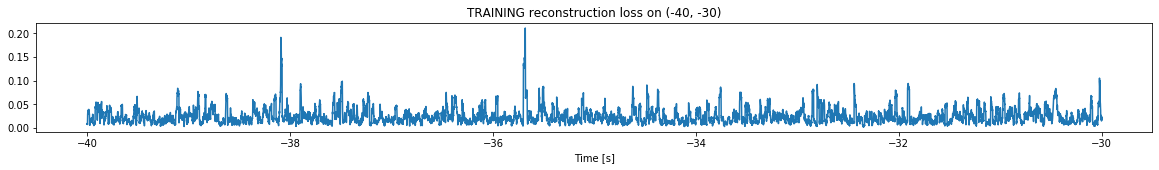

Finished training, median of the log(loss) is:  -1.6787875083789658
Triggering for section:  (-30, -20)
Using this median for triggering: -1.9668304889245738


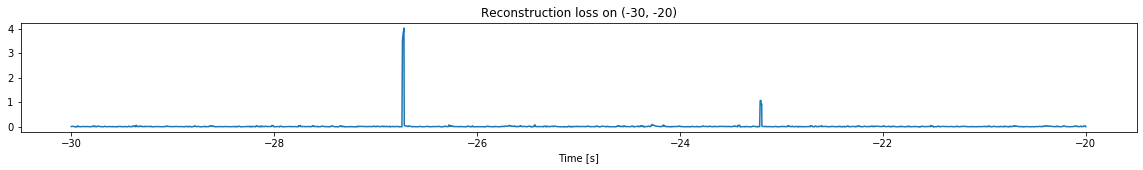

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


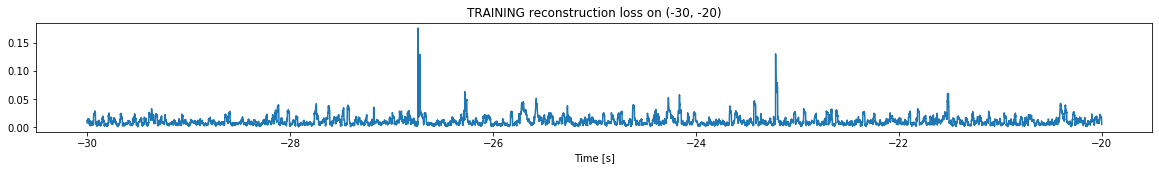

Finished training, median of the log(loss) is:  -2.0416031830786094
Triggering for section:  (-20, -10)
Using this median for triggering: -1.6787875083789658


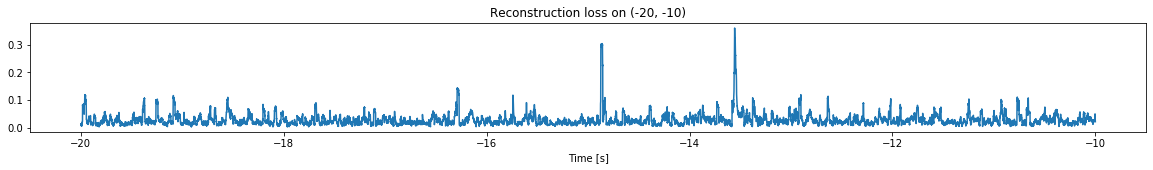

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


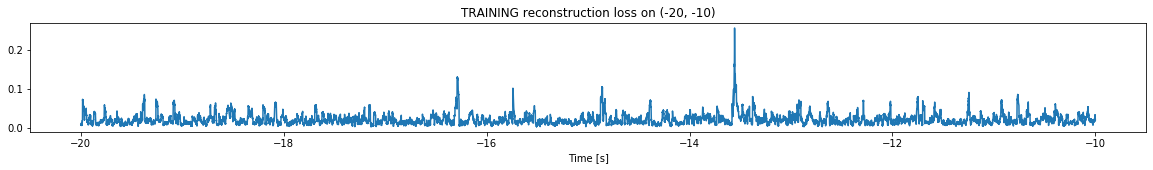

Finished training, median of the log(loss) is:  -1.744753254453423
Triggering for section:  (-10, 0)
Using this median for triggering: -2.0416031830786094


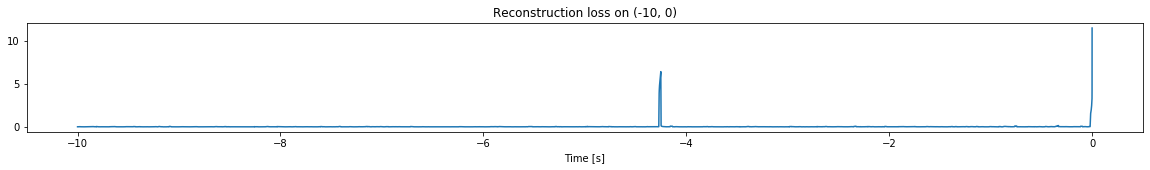

<--------
Finished simulation, all the triggered times are:  []


In [7]:
simulation("./data/Ramp5/", 10, (-90,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (997500, 12)
Flushing input history
Number of sections: 10
Entering sections:  (-100, -90)
-------->
Entering sections:  (-90, -80)
-------->
Training for section:  (None, -90)


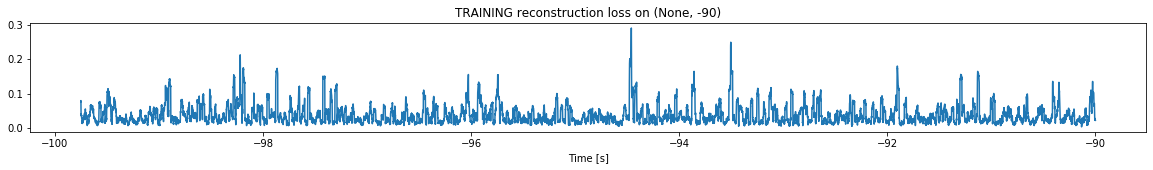

Finished training, median of the log(loss) is:  -1.5291126259269217
<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


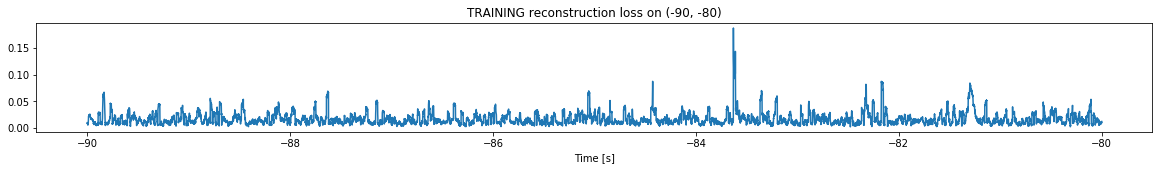

Finished training, median of the log(loss) is:  -1.843904989729339
Triggering for section:  (-80, -70)
Using this median for triggering: -1.5291126259269217


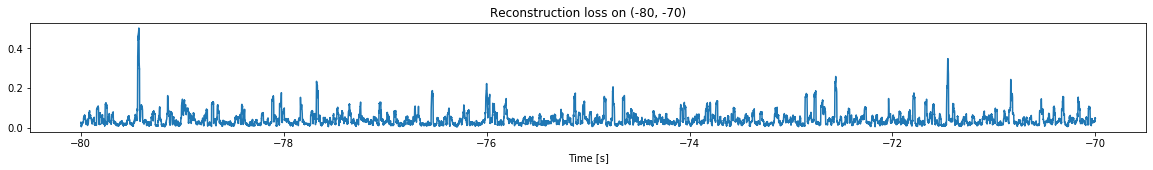

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


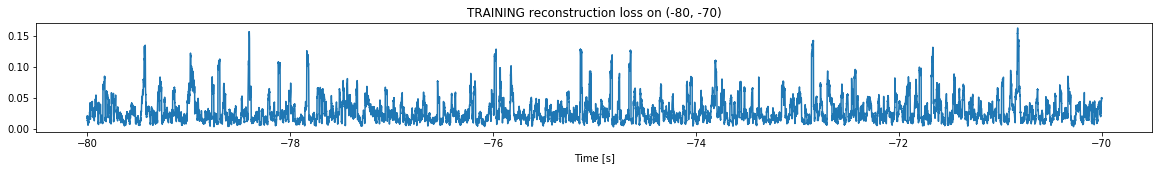

Finished training, median of the log(loss) is:  -1.6341034690274636
Triggering for section:  (-70, -60)
Using this median for triggering: -1.843904989729339


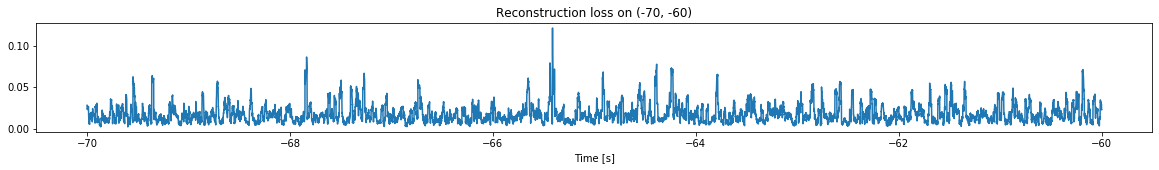

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


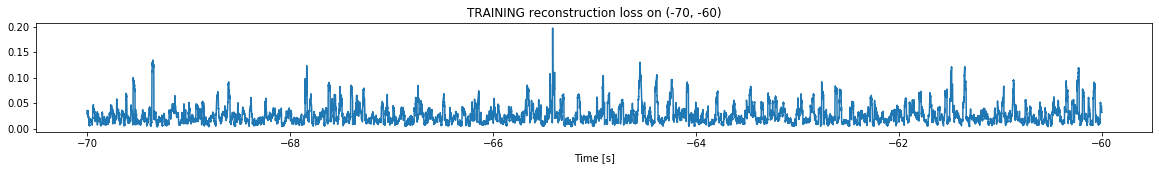

Finished training, median of the log(loss) is:  -1.6669580969471642
Triggering for section:  (-60, -50)
Using this median for triggering: -1.6341034690274636


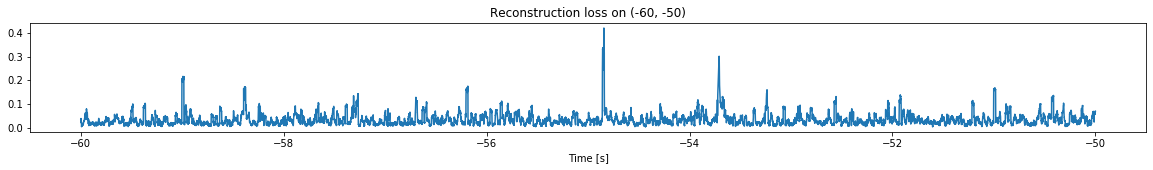

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


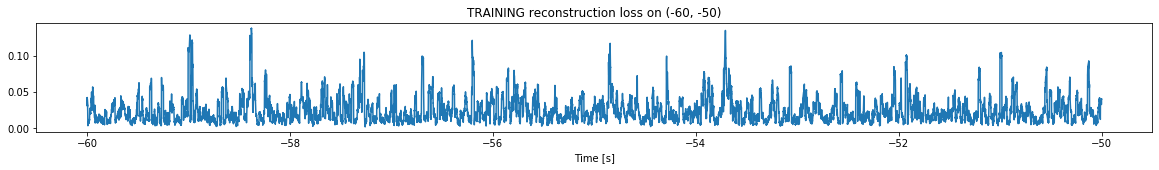

Finished training, median of the log(loss) is:  -1.6974477232982679
Triggering for section:  (-50, -40)
Using this median for triggering: -1.6669580969471642


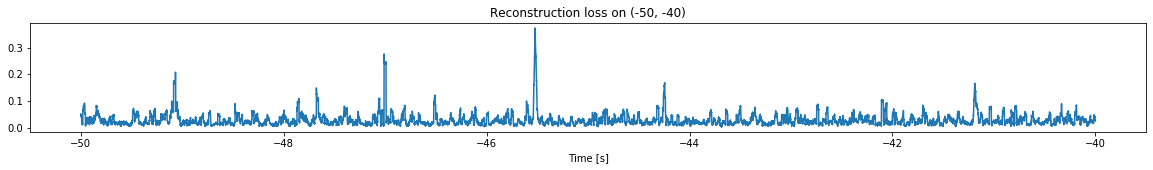

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


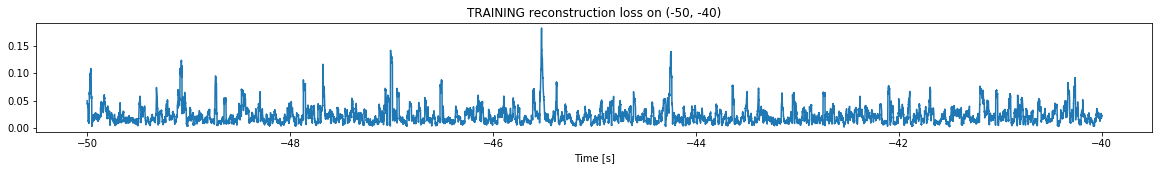

Finished training, median of the log(loss) is:  -1.7253319344236293
Triggering for section:  (-40, -30)
Using this median for triggering: -1.6974477232982679


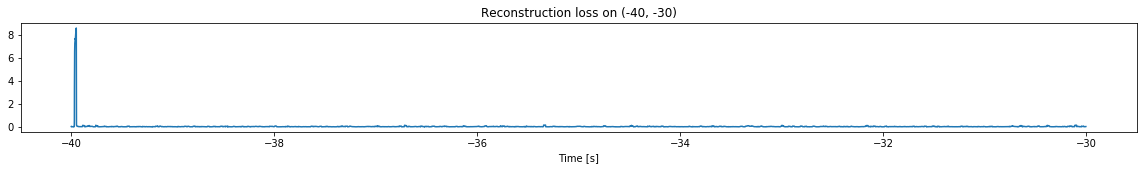

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


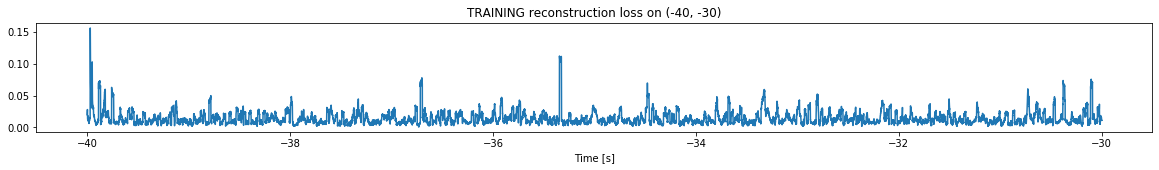

Finished training, median of the log(loss) is:  -1.9356998660350393
Triggering for section:  (-30, -20)
Using this median for triggering: -1.7253319344236293


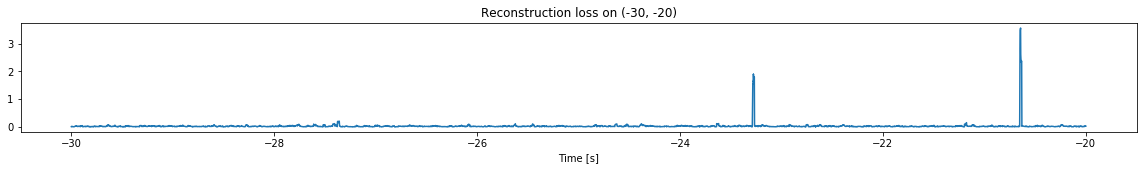

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


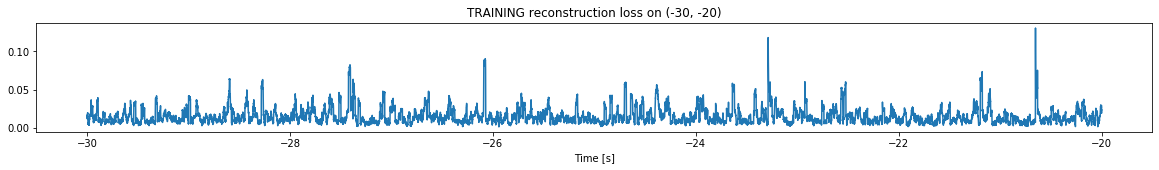

Finished training, median of the log(loss) is:  -1.8881772223234008
Triggering for section:  (-20, -10)
Using this median for triggering: -1.9356998660350393


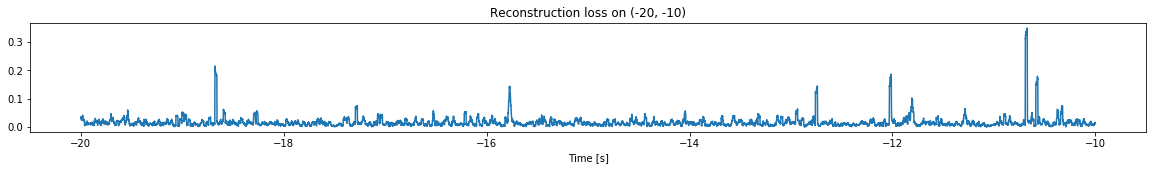

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


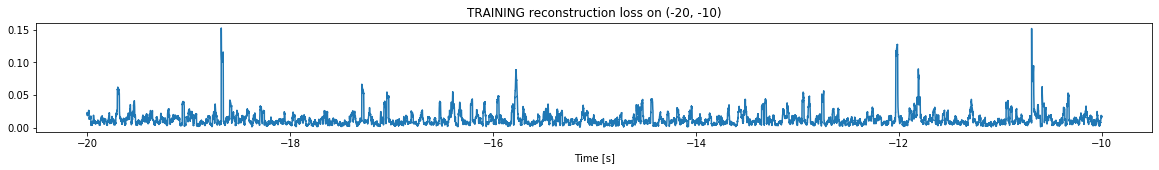

Finished training, median of the log(loss) is:  -1.9738051300614827
Triggering for section:  (-10, 0)
Using this median for triggering: -1.8881772223234008


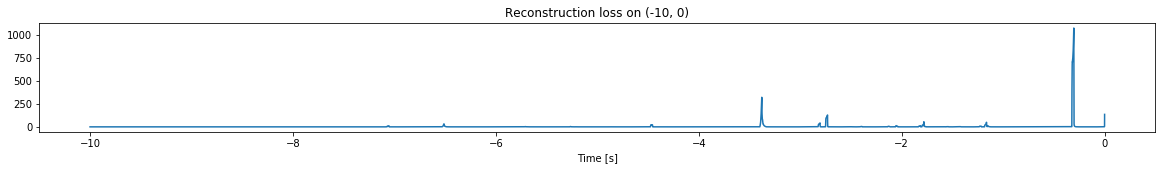

Other trigger time:  [-6.5119996  -3.3790998  -2.731      -1.7816     -1.1640999  -0.30359998]
Their log loss values are:  [1.51222461 2.50611908 2.10907864 1.74302652 1.69431125 3.03024606]


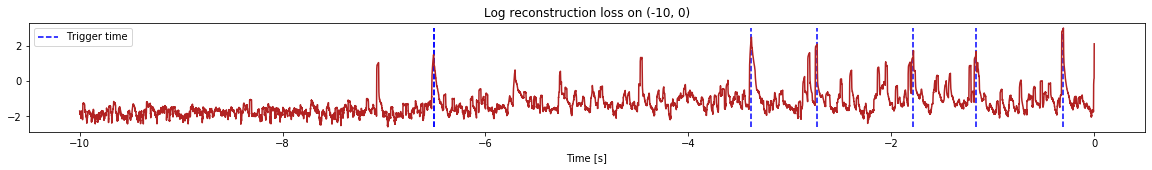

Triggered at:  [-6.5119996, -3.3790998, -2.731, -1.7816, -1.1640999, -0.30359998]
<--------
Finished simulation, all the triggered times are:  [-6.5119996, -3.3790998, -2.731, -1.7816, -1.1640999, -0.30359998]


In [8]:
simulation("./data/Ramp12d/", 10, (-100,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (2997500, 12)
Flushing input history
Number of sections: 30
Entering sections:  (-300, -290)
-------->
Entering sections:  (-290, -280)
-------->
Training for section:  (None, -290)


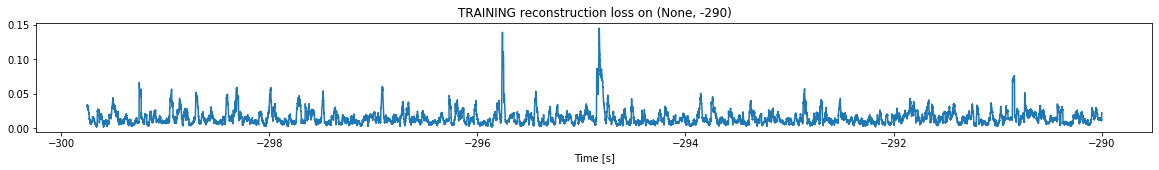

Finished training, median of the log(loss) is:  -1.8927703476168298
<--------
Entering sections:  (-280, -270)
-------->
Training for section:  (-290, -280)


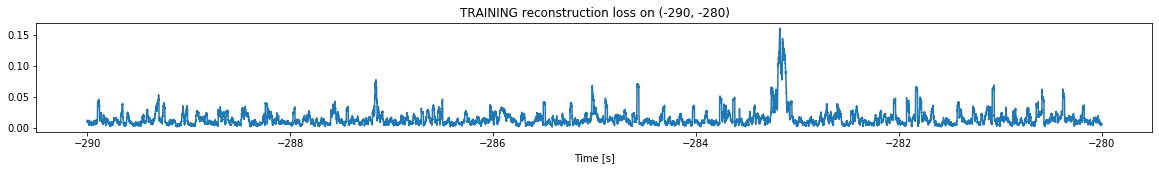

Finished training, median of the log(loss) is:  -1.9650178052774865
Triggering for section:  (-280, -270)
Using this median for triggering: -1.8927703476168298


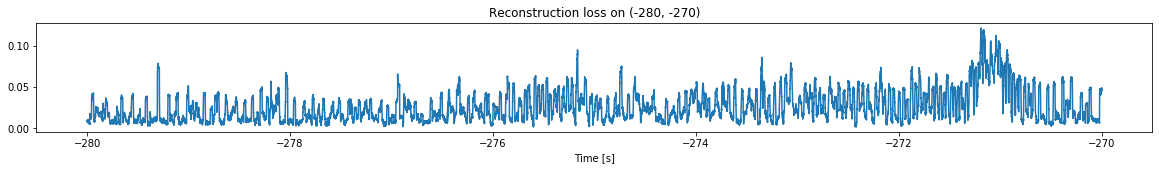

<--------
Entering sections:  (-270, -260)
-------->
Training for section:  (-280, -270)


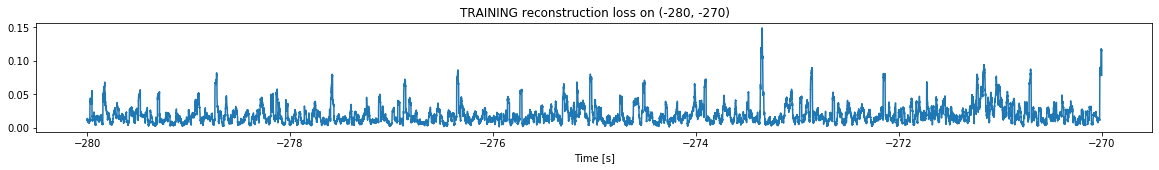

Finished training, median of the log(loss) is:  -1.7966213315554465
Triggering for section:  (-270, -260)
Using this median for triggering: -1.9650178052774865


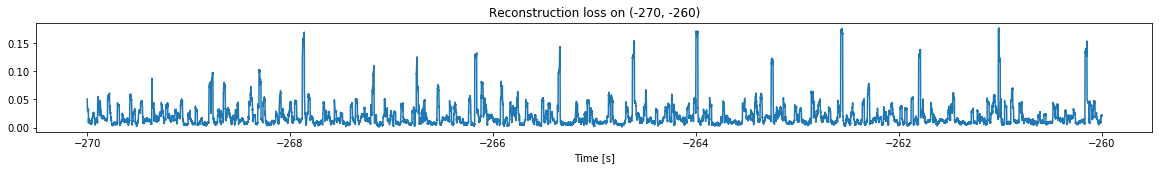

<--------
Entering sections:  (-260, -250)
-------->
Training for section:  (-270, -260)


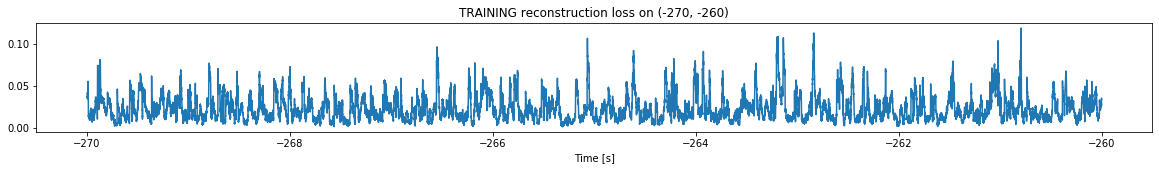

Finished training, median of the log(loss) is:  -1.6950748197247618
Triggering for section:  (-260, -250)
Using this median for triggering: -1.7966213315554465


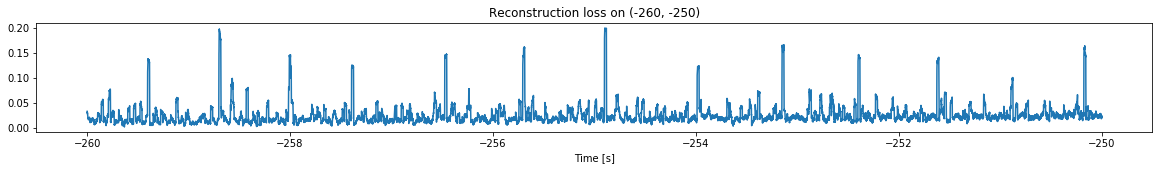

<--------
Entering sections:  (-250, -240)
-------->
Training for section:  (-260, -250)


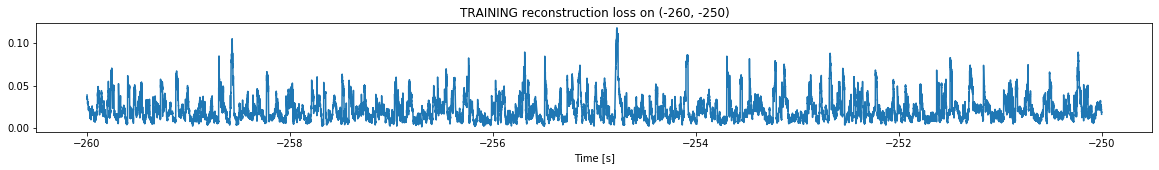

Finished training, median of the log(loss) is:  -1.7372004359559976
Triggering for section:  (-250, -240)
Using this median for triggering: -1.6950748197247618


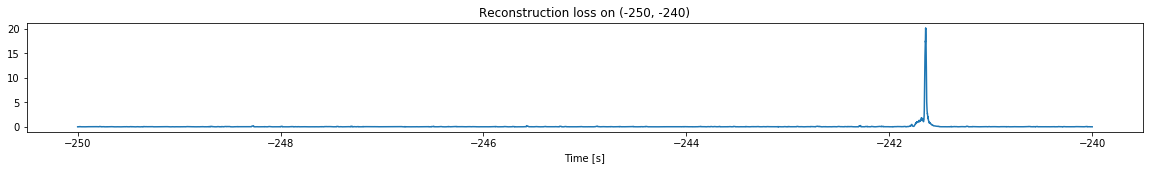

<--------
Entering sections:  (-240, -230)
-------->
Training for section:  (-250, -240)


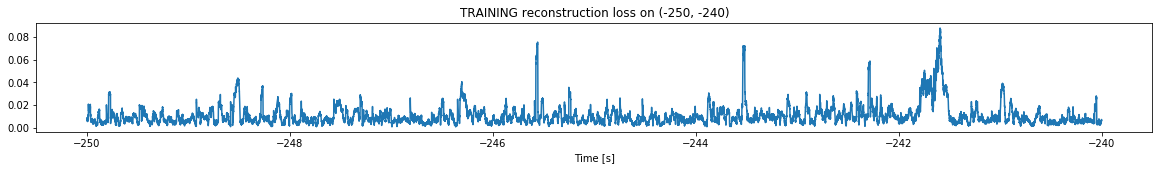

Finished training, median of the log(loss) is:  -2.060404878690689
Triggering for section:  (-240, -230)
Using this median for triggering: -1.7372004359559976


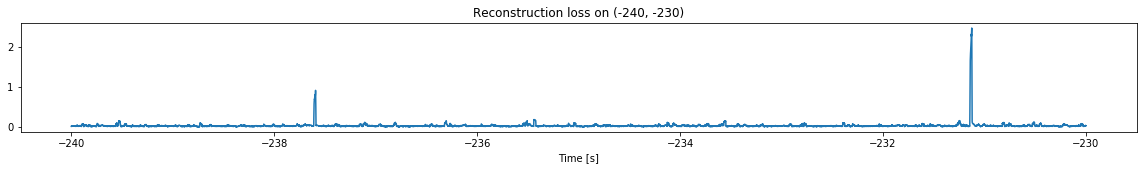

<--------
Entering sections:  (-230, -220)
-------->
Training for section:  (-240, -230)


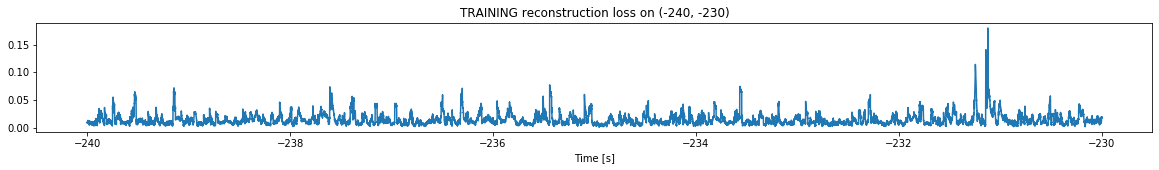

Finished training, median of the log(loss) is:  -1.9314257861271098
Triggering for section:  (-230, -220)
Using this median for triggering: -2.060404878690689


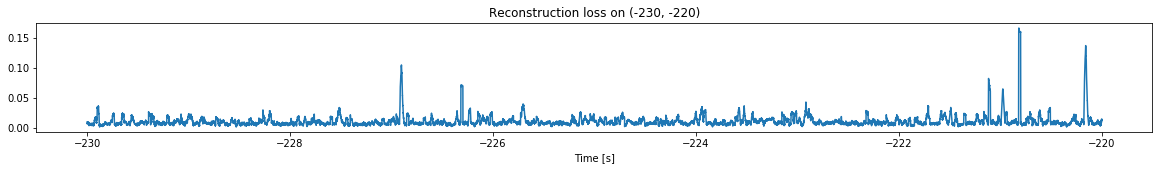

<--------
Entering sections:  (-220, -210)
-------->
Training for section:  (-230, -220)


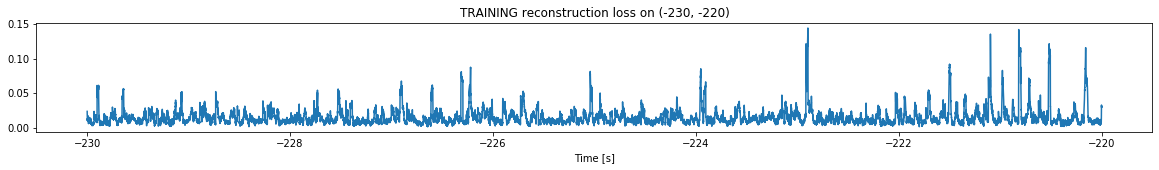

Finished training, median of the log(loss) is:  -1.9233559744473099
Triggering for section:  (-220, -210)
Using this median for triggering: -1.9314257861271098


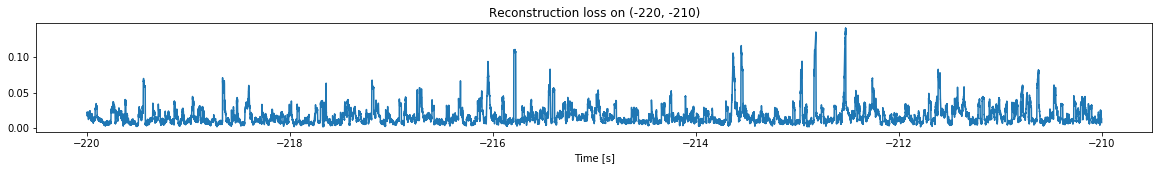

<--------
Entering sections:  (-210, -200)
-------->
Training for section:  (-220, -210)


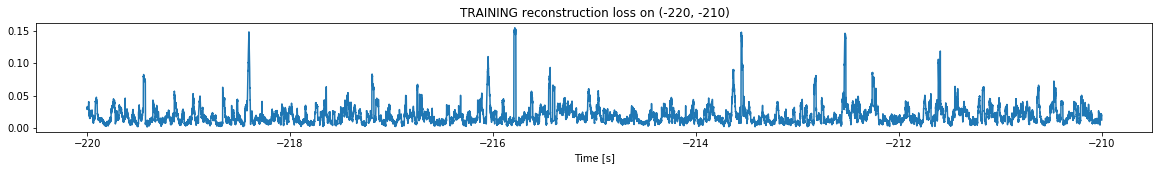

Finished training, median of the log(loss) is:  -1.7966257368160368
Triggering for section:  (-210, -200)
Using this median for triggering: -1.9233559744473099


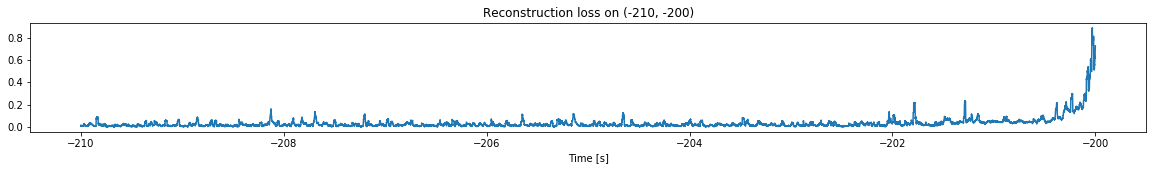

<--------
Entering sections:  (-200, -190)
-------->
Training for section:  (-210, -200)


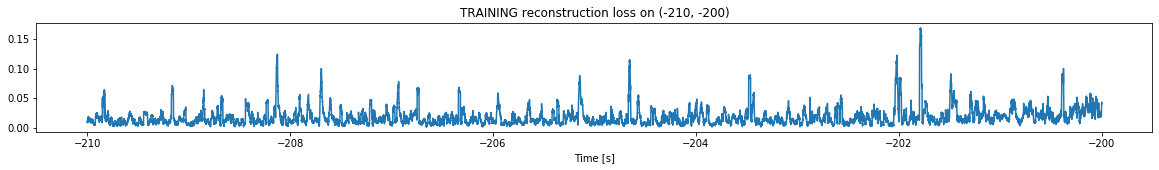

Finished training, median of the log(loss) is:  -1.8340265614799856
Triggering for section:  (-200, -190)
Using this median for triggering: -1.7966257368160368


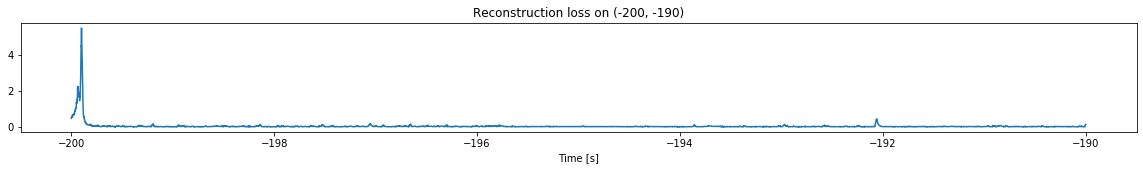

<--------
Entering sections:  (-190, -180)
-------->
Training for section:  (-200, -190)


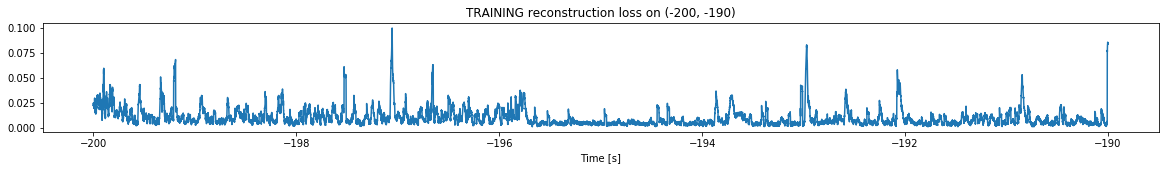

Finished training, median of the log(loss) is:  -2.1352134263890212
Triggering for section:  (-190, -180)
Using this median for triggering: -1.8340265614799856


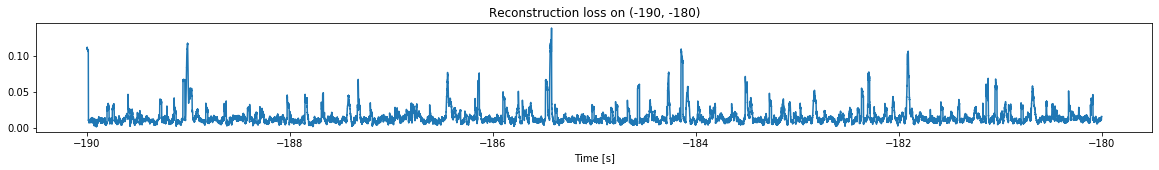

<--------
Entering sections:  (-180, -170)
-------->
Training for section:  (-190, -180)


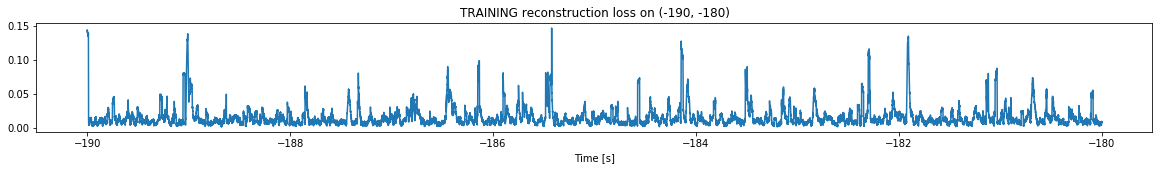

Finished training, median of the log(loss) is:  -1.9538008690603443
Triggering for section:  (-180, -170)
Using this median for triggering: -2.1352134263890212


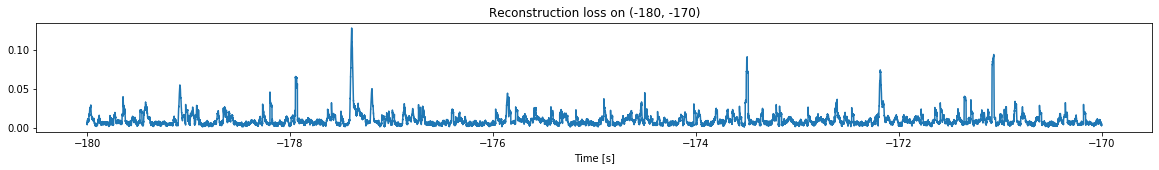

<--------
Entering sections:  (-170, -160)
-------->
Training for section:  (-180, -170)


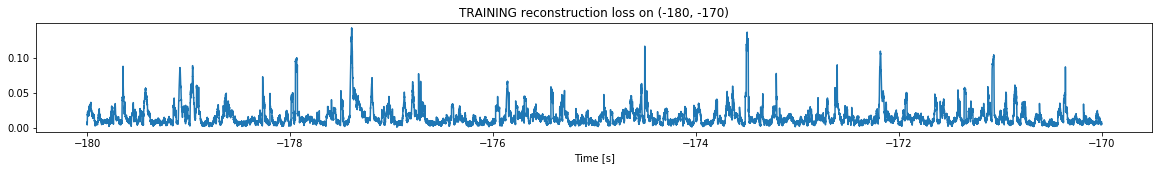

Finished training, median of the log(loss) is:  -1.9253441626973955
Triggering for section:  (-170, -160)
Using this median for triggering: -1.9538008690603443


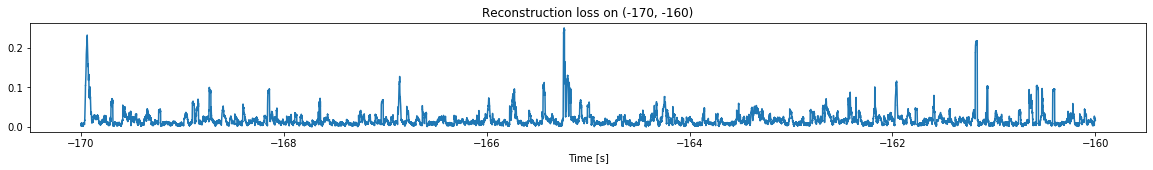

<--------
Entering sections:  (-160, -150)
-------->
Training for section:  (-170, -160)


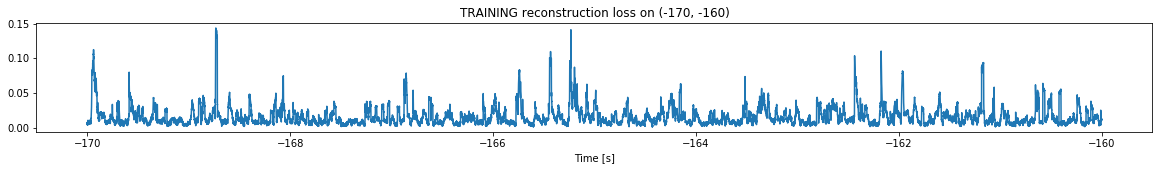

Finished training, median of the log(loss) is:  -1.9264555925183926
Triggering for section:  (-160, -150)
Using this median for triggering: -1.9253441626973955


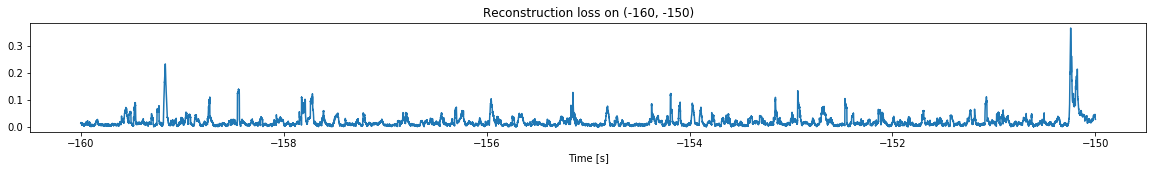

<--------
Entering sections:  (-150, -140)
-------->
Training for section:  (-160, -150)


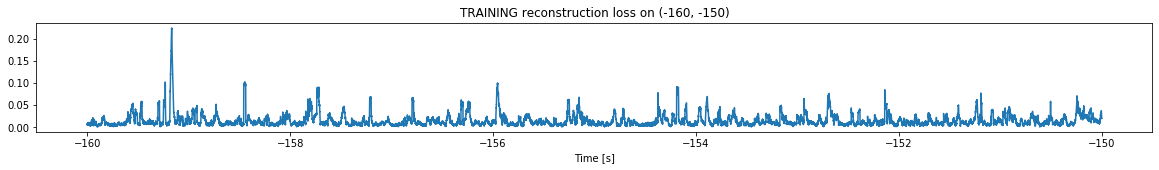

Finished training, median of the log(loss) is:  -1.9596436512341935
Triggering for section:  (-150, -140)
Using this median for triggering: -1.9264555925183926


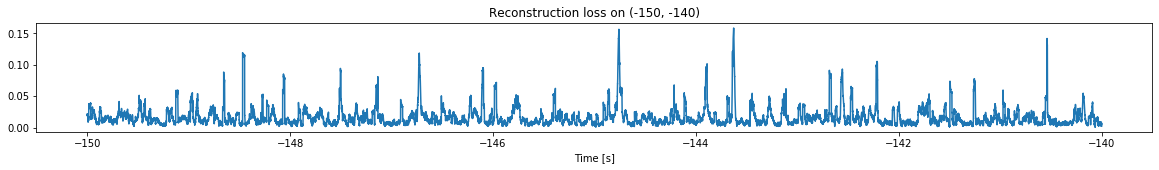

<--------
Entering sections:  (-140, -130)
-------->
Training for section:  (-150, -140)


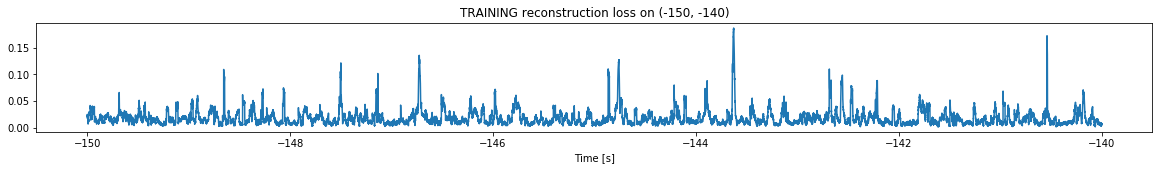

Finished training, median of the log(loss) is:  -1.85228776143878
Triggering for section:  (-140, -130)
Using this median for triggering: -1.9596436512341935


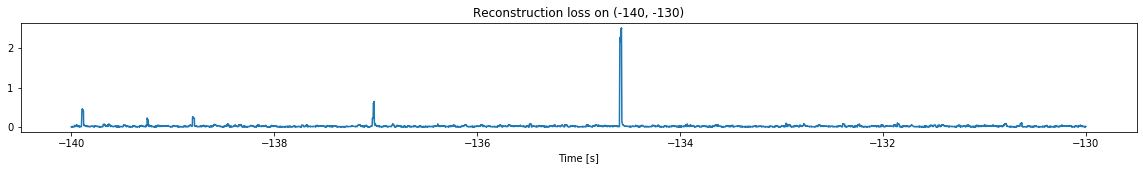

<--------
Entering sections:  (-130, -120)
-------->
Training for section:  (-140, -130)


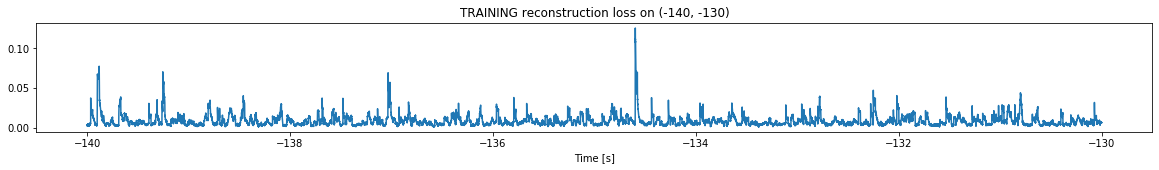

Finished training, median of the log(loss) is:  -2.170251087347639
Triggering for section:  (-130, -120)
Using this median for triggering: -1.85228776143878


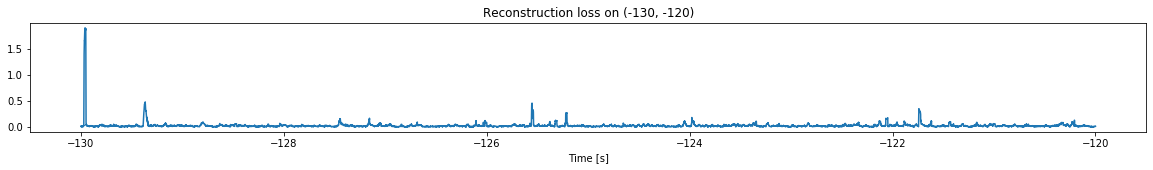

<--------
Entering sections:  (-120, -110)
-------->
Training for section:  (-130, -120)


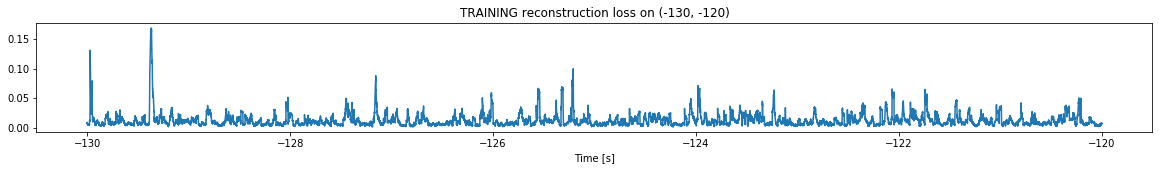

Finished training, median of the log(loss) is:  -2.0252975945390816
Triggering for section:  (-120, -110)
Using this median for triggering: -2.170251087347639


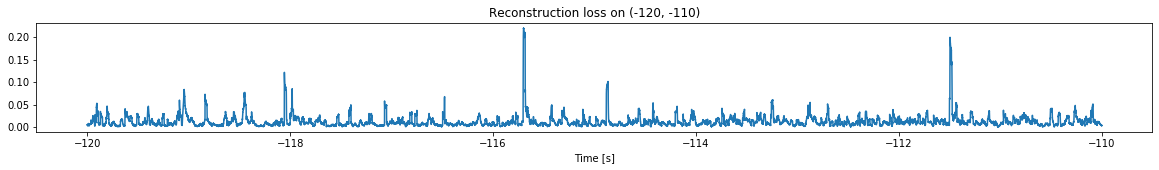

<--------
Entering sections:  (-110, -100)
-------->
Training for section:  (-120, -110)


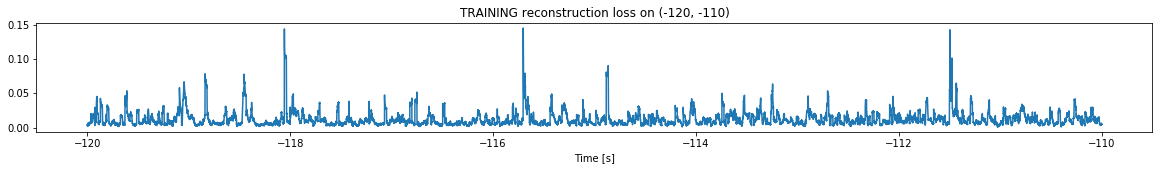

Finished training, median of the log(loss) is:  -2.0294987862479297
Triggering for section:  (-110, -100)
Using this median for triggering: -2.0252975945390816


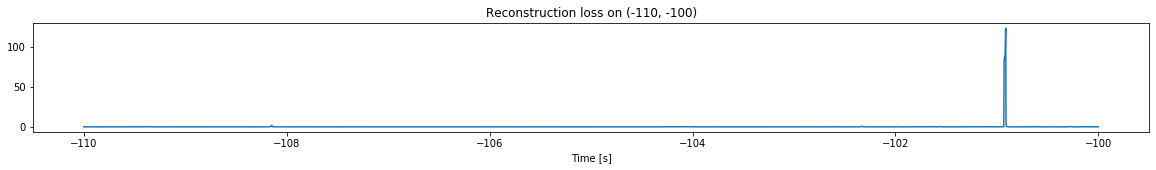

Other trigger time:  [-100.91249]
Their log loss values are:  [2.09426499]


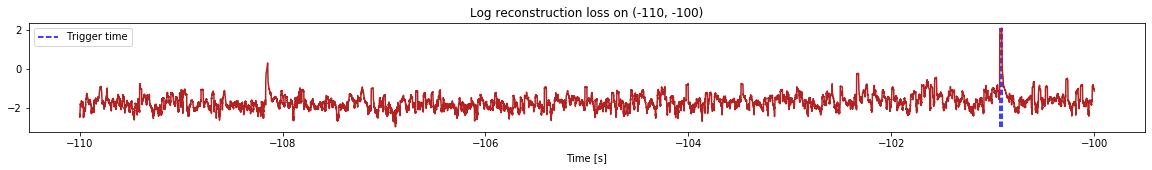

Triggered at:  [-100.91249]
<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


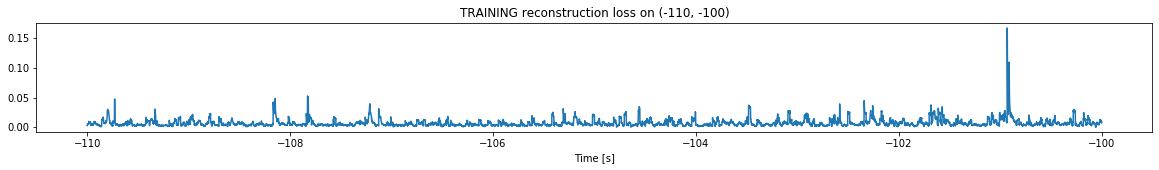

Finished training, median of the log(loss) is:  -2.2642934465143685
Triggering for section:  (-100, -90)
Using this median for triggering: -2.0294987862479297


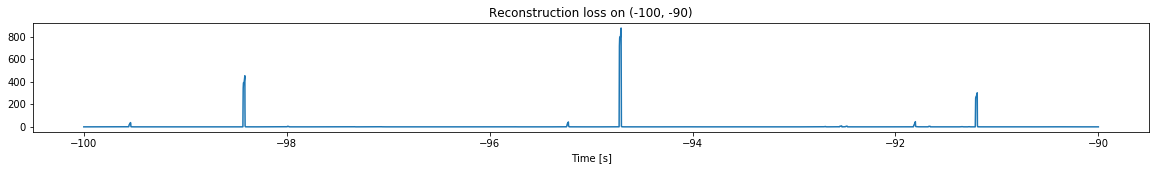

Other trigger time:  [-99.53959  -98.41249  -95.22369  -94.704185 -91.80379  -91.193886]
Their log loss values are:  [1.58065543 2.65612444 1.63668666 2.94251628 1.66350833 2.48035148]


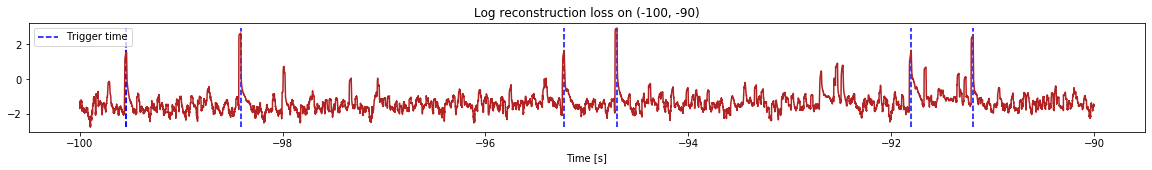

Triggered at:  [-99.53959, -98.41249, -95.22369, -94.704185, -91.80379, -91.193886]
<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


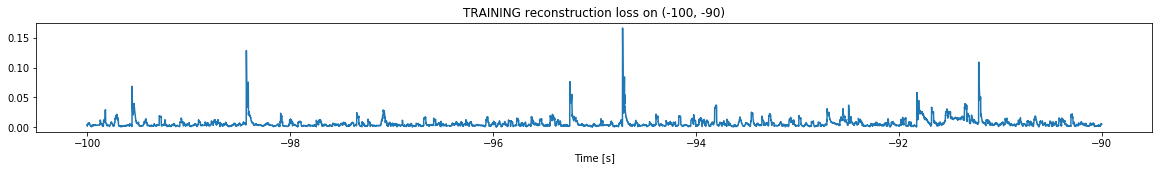

Finished training, median of the log(loss) is:  -2.321096604139906
Triggering for section:  (-90, -80)
Using this median for triggering: -2.2642934465143685


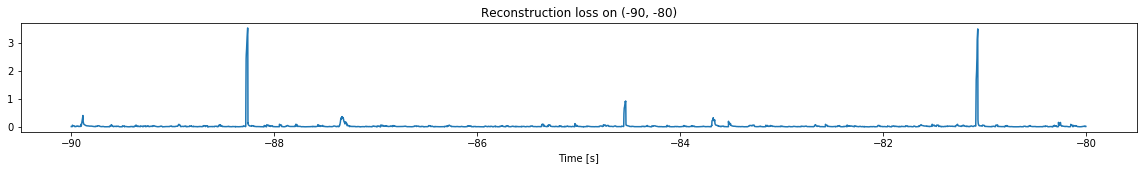

<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


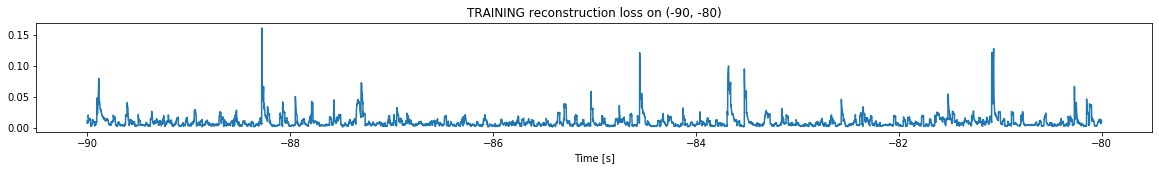

Finished training, median of the log(loss) is:  -2.208894215606577
Triggering for section:  (-80, -70)
Using this median for triggering: -2.321096604139906


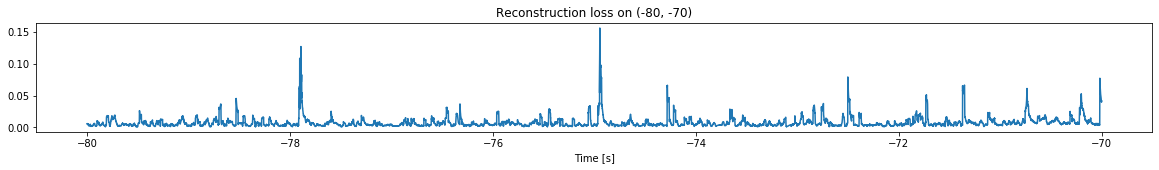

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


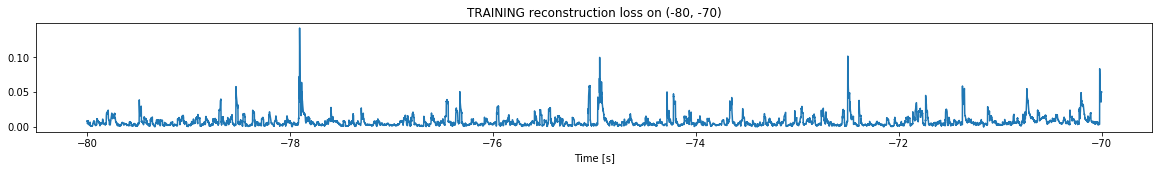

Finished training, median of the log(loss) is:  -2.235468059455817
Triggering for section:  (-70, -60)
Using this median for triggering: -2.208894215606577


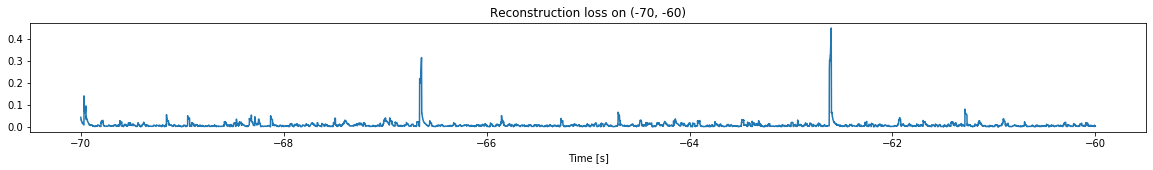

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


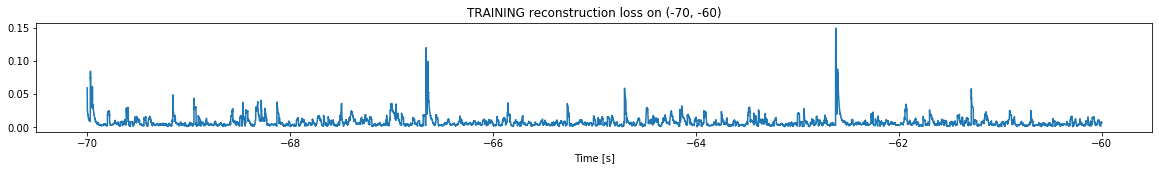

Finished training, median of the log(loss) is:  -2.2354748941450735
Triggering for section:  (-60, -50)
Using this median for triggering: -2.235468059455817


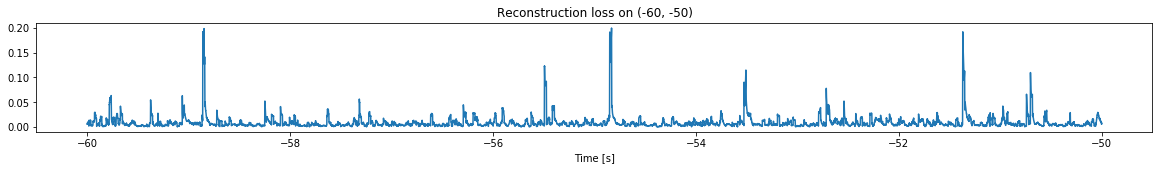

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


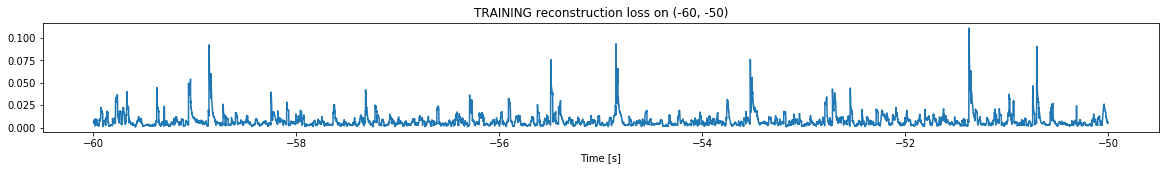

Finished training, median of the log(loss) is:  -2.2610884662842805
Triggering for section:  (-50, -40)
Using this median for triggering: -2.2354748941450735


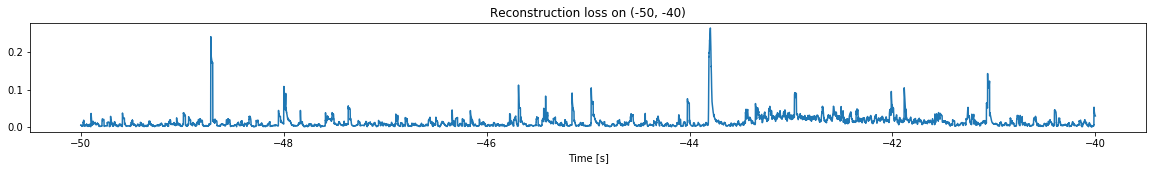

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


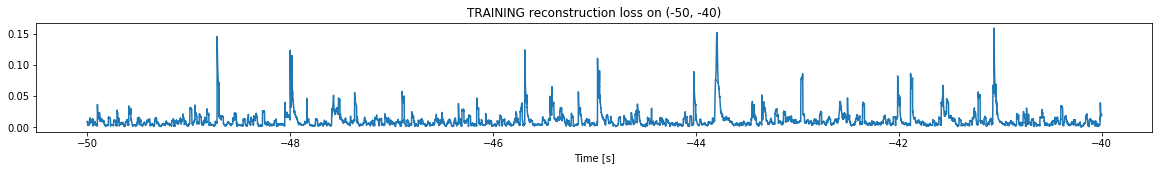

Finished training, median of the log(loss) is:  -2.111198084431073
Triggering for section:  (-40, -30)
Using this median for triggering: -2.2610884662842805


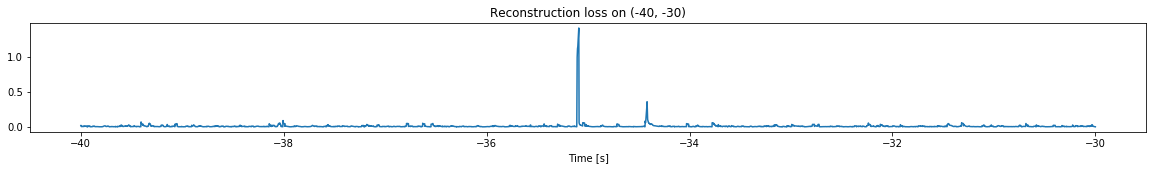

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


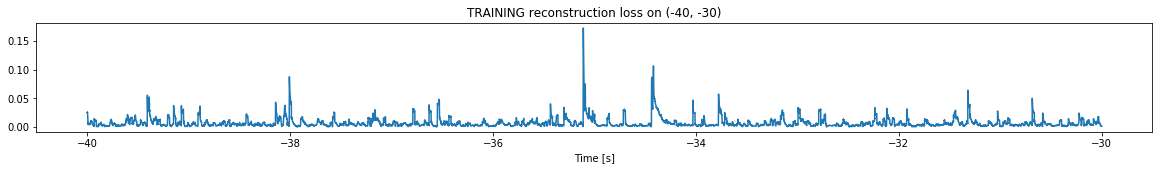

Finished training, median of the log(loss) is:  -2.3059903127663066
Triggering for section:  (-30, -20)
Using this median for triggering: -2.111198084431073


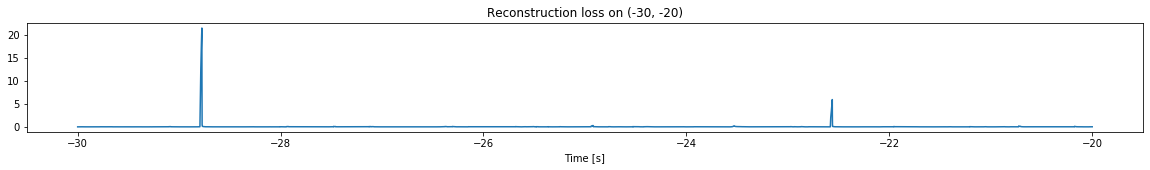

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


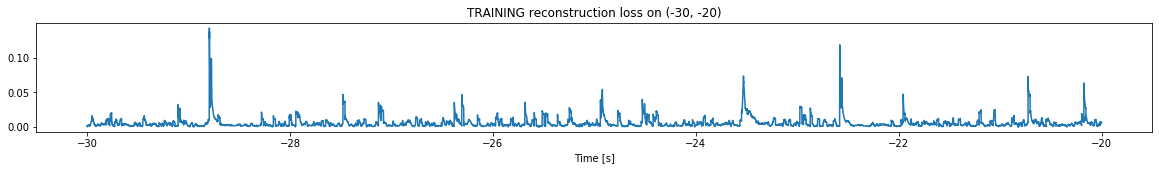

Finished training, median of the log(loss) is:  -2.394097355277044
Triggering for section:  (-20, -10)
Using this median for triggering: -2.3059903127663066


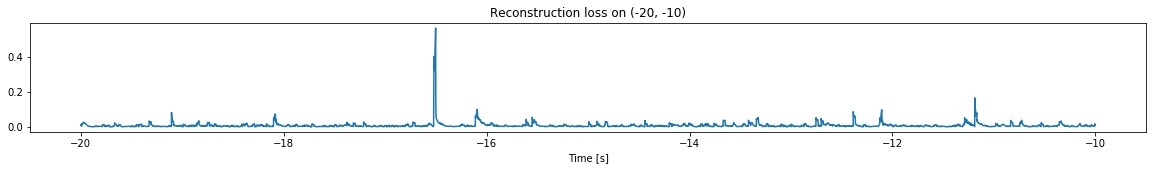

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


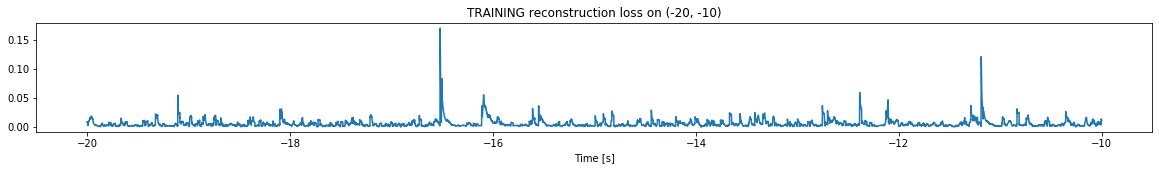

Finished training, median of the log(loss) is:  -2.3675070853443785
Triggering for section:  (-10, 0)
Using this median for triggering: -2.394097355277044


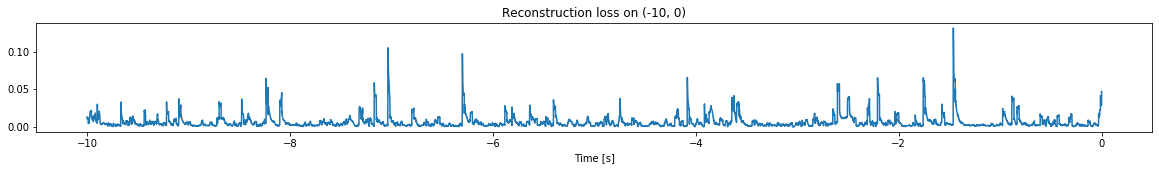

<--------
Finished simulation, all the triggered times are:  [-100.91249, -99.53959, -98.41249, -95.22369, -94.704185, -91.80379, -91.193886]


In [9]:
simulation("./data/Ramp19/", 10, (-300,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (2117500, 12)
Flushing input history
Number of sections: 21
Entering sections:  (-210, -200)
-------->
Entering sections:  (-200, -190)
-------->
Training for section:  (None, -200)


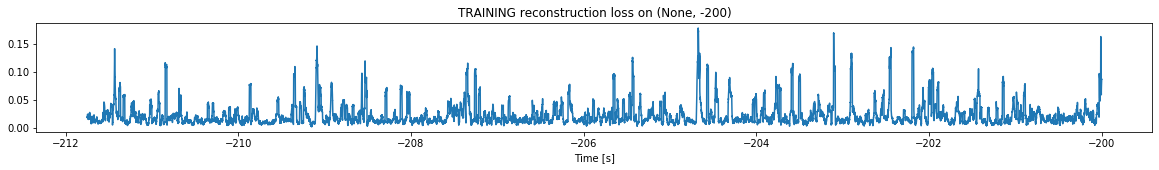

Finished training, median of the log(loss) is:  -1.7773147038160009
<--------
Entering sections:  (-190, -180)
-------->
Training for section:  (-200, -190)


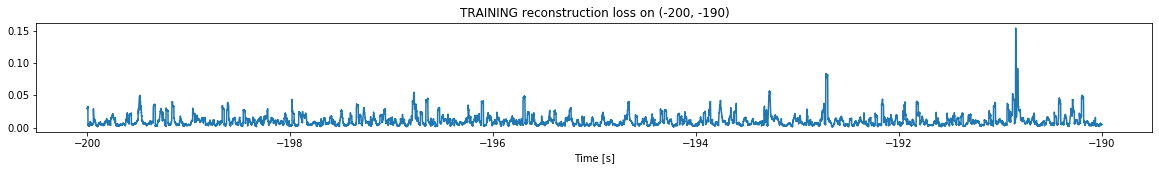

Finished training, median of the log(loss) is:  -2.1076181107792467
Triggering for section:  (-190, -180)
Using this median for triggering: -1.7773147038160009


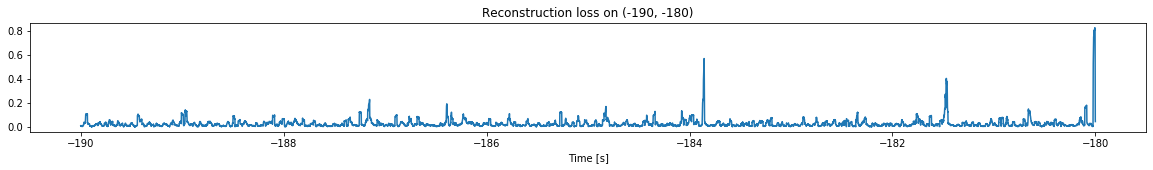

<--------
Entering sections:  (-180, -170)
-------->
Training for section:  (-190, -180)


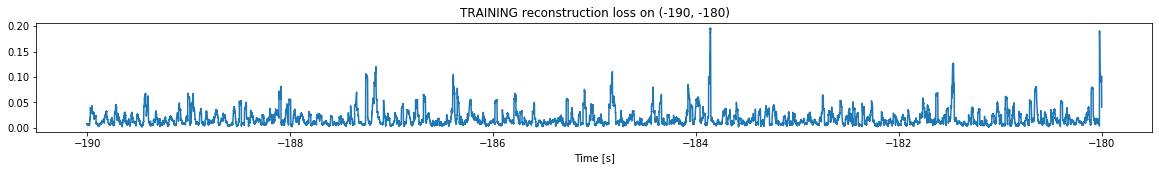

Finished training, median of the log(loss) is:  -1.8681907767884571
Triggering for section:  (-180, -170)
Using this median for triggering: -2.1076181107792467


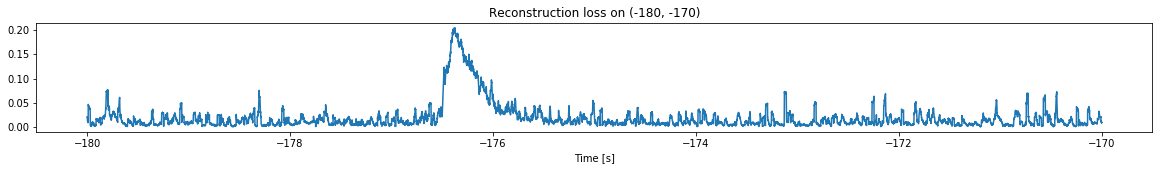

<--------
Entering sections:  (-170, -160)
-------->
Training for section:  (-180, -170)


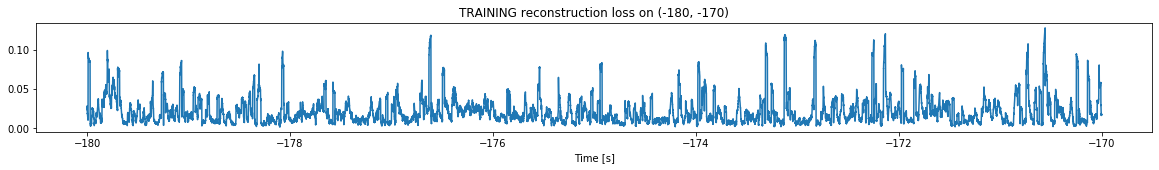

Finished training, median of the log(loss) is:  -1.769468430980681
Triggering for section:  (-170, -160)
Using this median for triggering: -1.8681907767884571


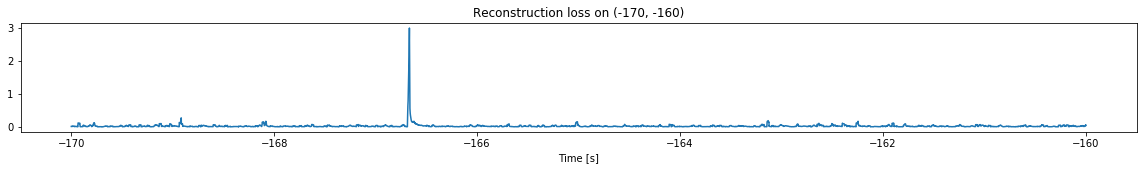

<--------
Entering sections:  (-160, -150)
-------->
Training for section:  (-170, -160)


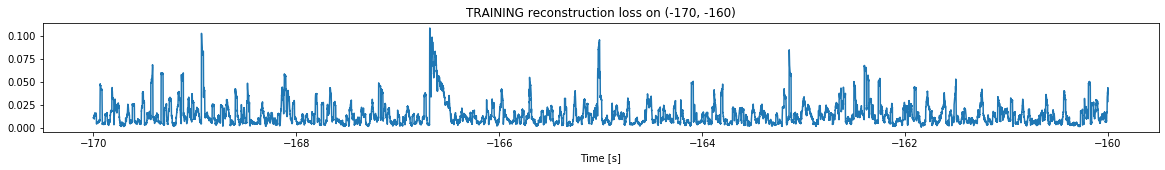

Finished training, median of the log(loss) is:  -1.977712975027179
Triggering for section:  (-160, -150)
Using this median for triggering: -1.769468430980681


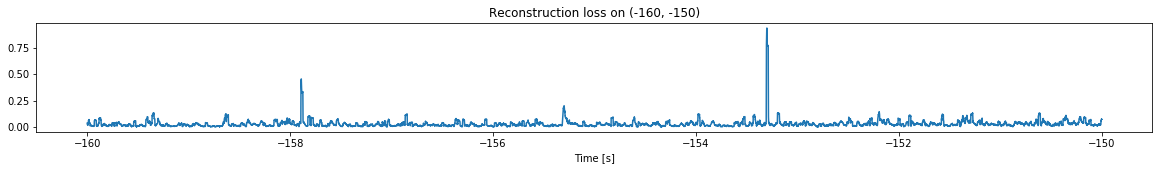

<--------
Entering sections:  (-150, -140)
-------->
Training for section:  (-160, -150)


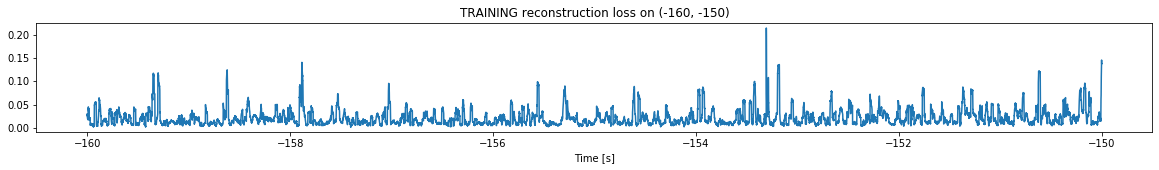

Finished training, median of the log(loss) is:  -1.7802117040601206
Triggering for section:  (-150, -140)
Using this median for triggering: -1.977712975027179


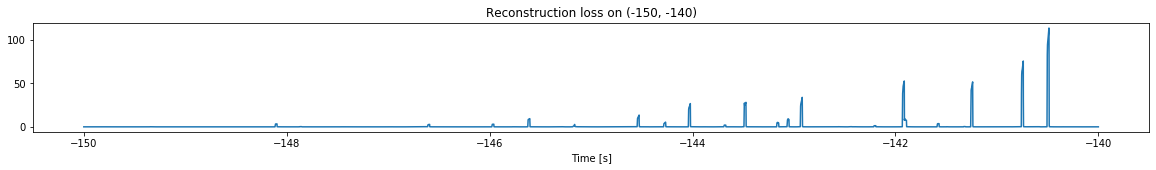

Other trigger time:  [-142.9188  -141.91309 -141.23909 -140.48679]
Their log loss values are:  [1.53136936 1.72300852 1.71474166 2.05656736]


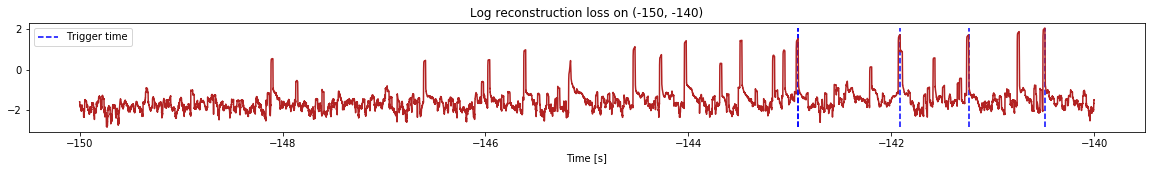

Triggered at:  [-142.9188, -141.91309, -141.23909, -140.48679]
<--------
Entering sections:  (-140, -130)
-------->
Training for section:  (-150, -140)


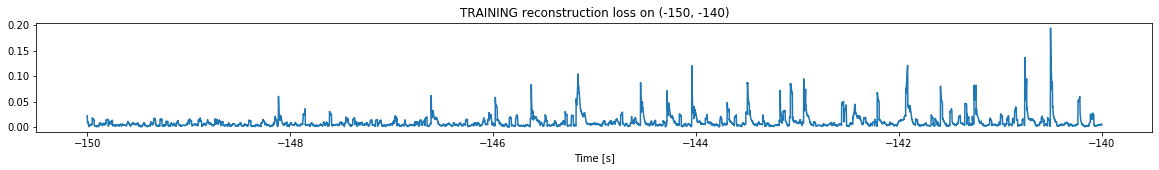

Finished training, median of the log(loss) is:  -2.2066746565391986
Triggering for section:  (-140, -130)
Using this median for triggering: -1.7802117040601206


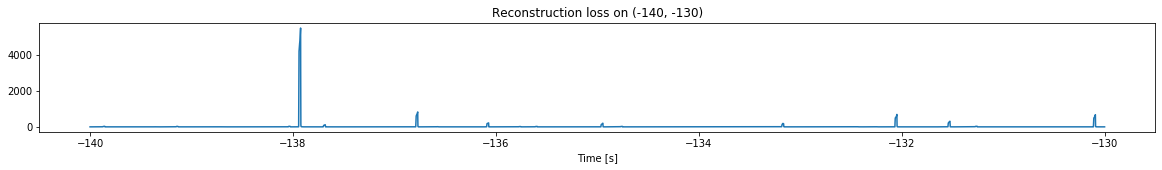

Other trigger time:  [-137.92479 -136.77028 -136.0718  -134.94579 -133.17009 -132.0474
 -131.52489 -130.09099]
Their log loss values are:  [3.73996108 2.91815675 2.34692083 2.31070117 2.28911714 2.83952284
 2.49648045 2.82969078]


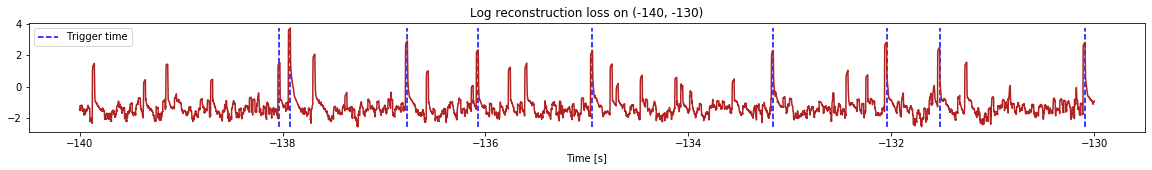

Triggered at:  [-137.92479, -136.77028, -136.0718, -134.94579, -133.17009, -132.0474, -131.52489, -130.09099]
<--------
Entering sections:  (-130, -120)
-------->
Training for section:  (-140, -130)


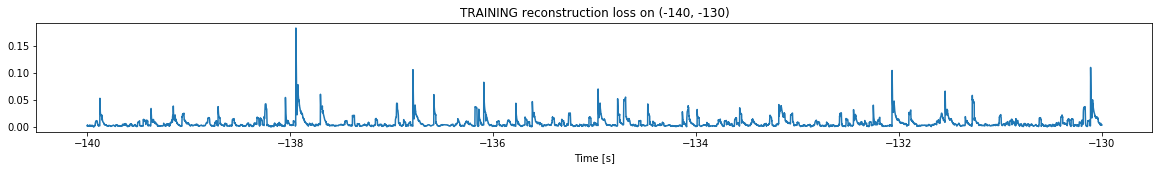

Finished training, median of the log(loss) is:  -2.3600439490079355
Triggering for section:  (-130, -120)
Using this median for triggering: -2.2066746565391986


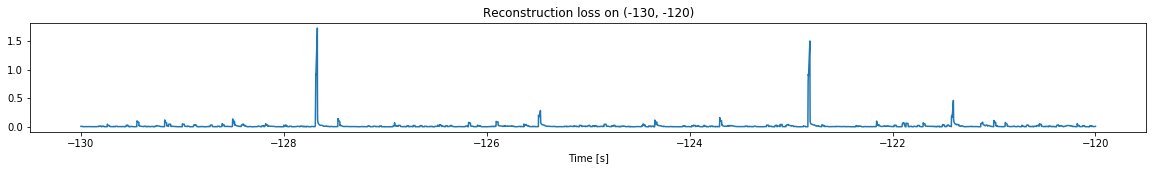

<--------
Entering sections:  (-120, -110)
-------->
Training for section:  (-130, -120)


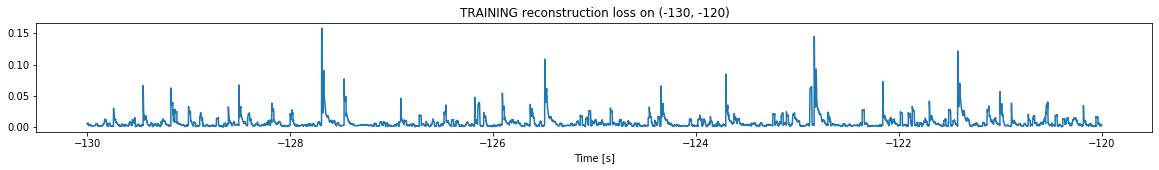

Finished training, median of the log(loss) is:  -2.3316981264057324
Triggering for section:  (-120, -110)
Using this median for triggering: -2.3600439490079355


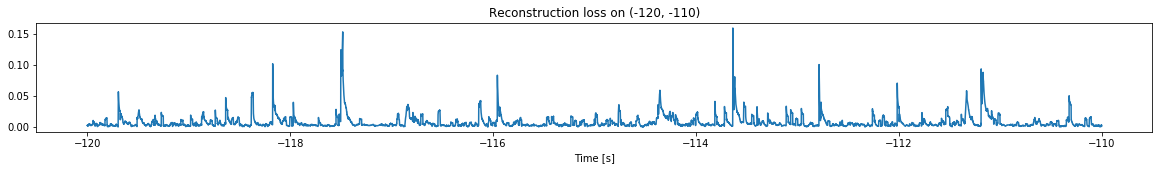

<--------
Entering sections:  (-110, -100)
-------->
Training for section:  (-120, -110)


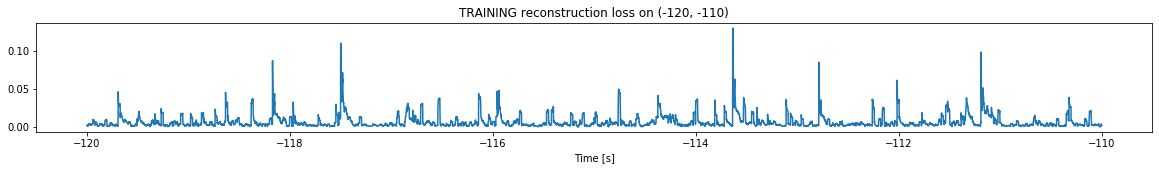

Finished training, median of the log(loss) is:  -2.39083311244734
Triggering for section:  (-110, -100)
Using this median for triggering: -2.3316981264057324


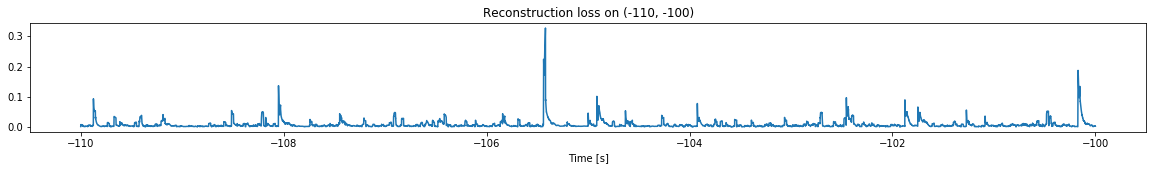

<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


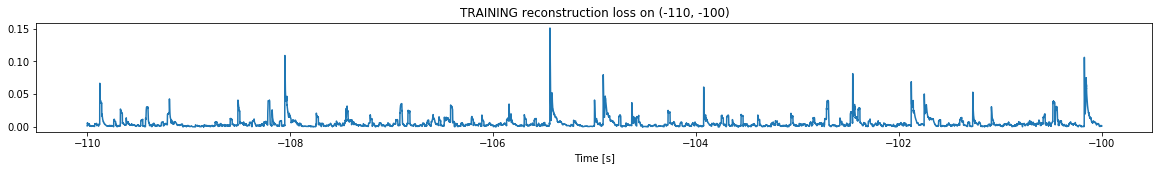

Finished training, median of the log(loss) is:  -2.444900371480405
Triggering for section:  (-100, -90)
Using this median for triggering: -2.39083311244734


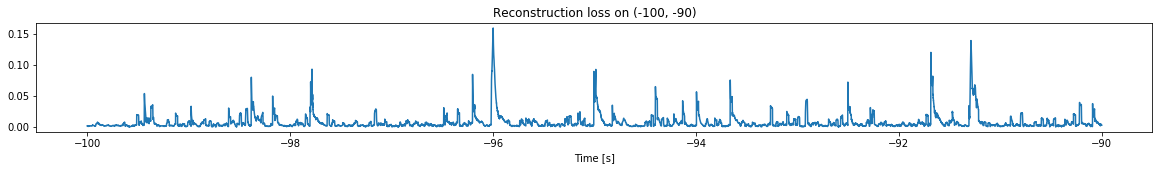

<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


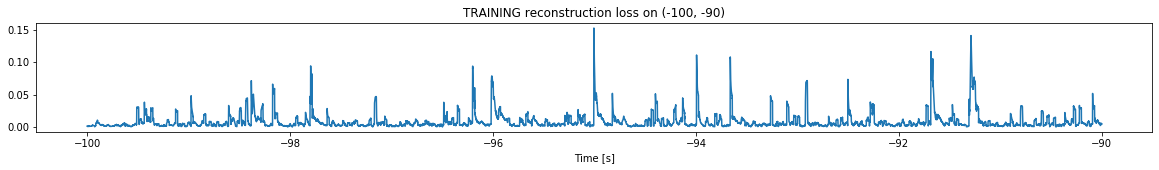

Finished training, median of the log(loss) is:  -2.3003471210108266
Triggering for section:  (-90, -80)
Using this median for triggering: -2.444900371480405


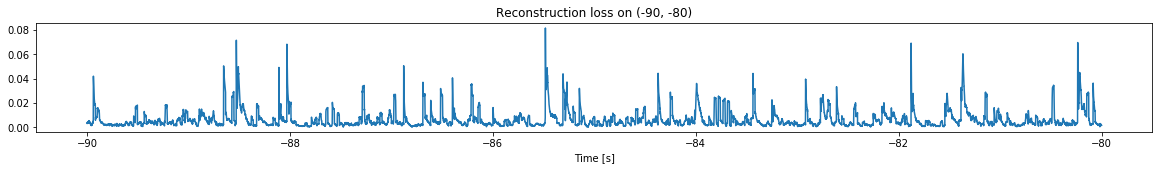

<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


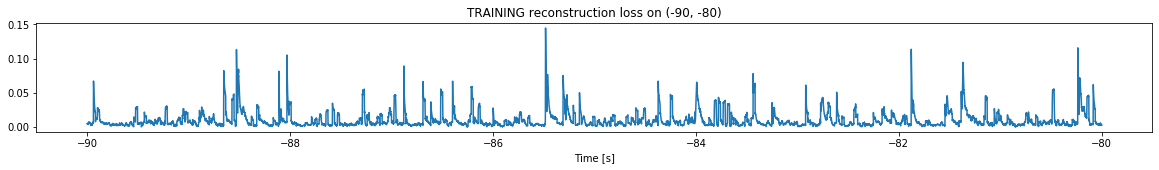

Finished training, median of the log(loss) is:  -2.174246855690364
Triggering for section:  (-80, -70)
Using this median for triggering: -2.3003471210108266


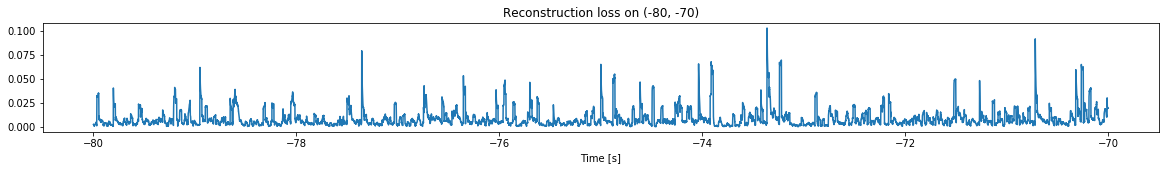

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


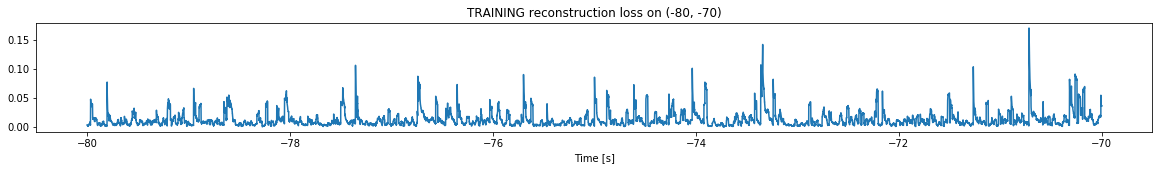

Finished training, median of the log(loss) is:  -2.016651708320986
Triggering for section:  (-70, -60)
Using this median for triggering: -2.174246855690364


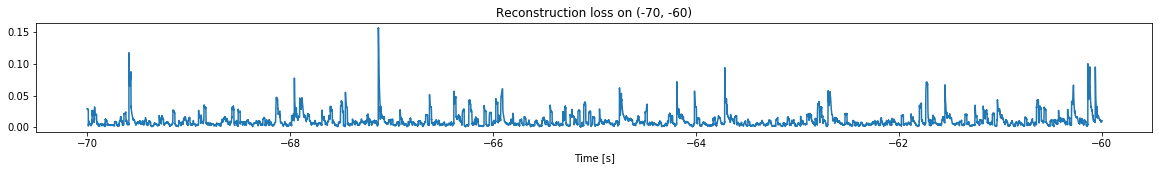

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


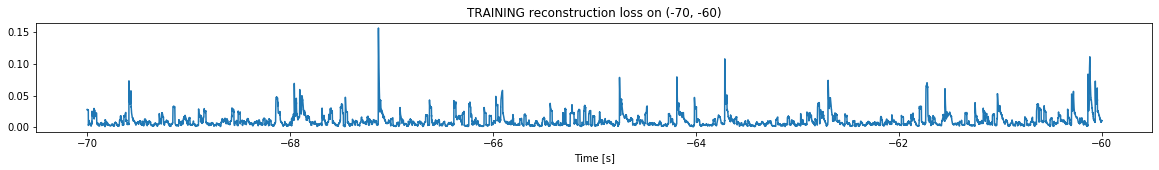

Finished training, median of the log(loss) is:  -2.15246061267864
Triggering for section:  (-60, -50)
Using this median for triggering: -2.016651708320986


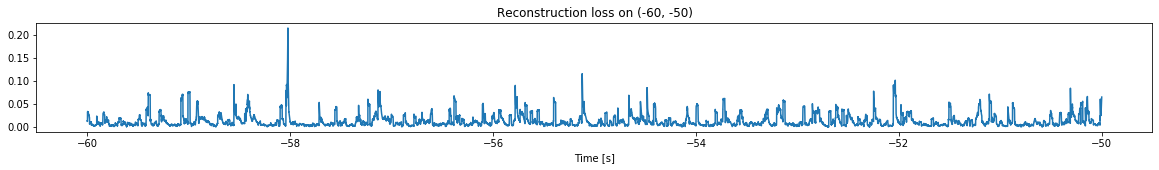

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


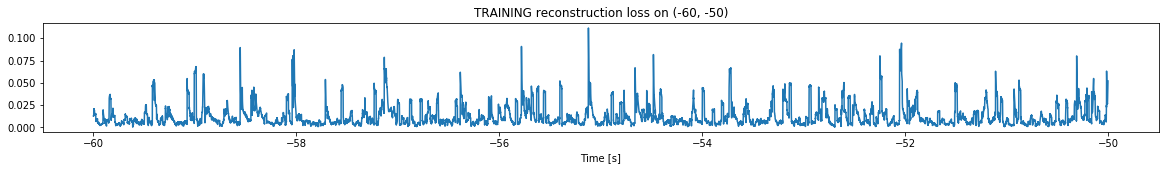

Finished training, median of the log(loss) is:  -2.0699974703719457
Triggering for section:  (-50, -40)
Using this median for triggering: -2.15246061267864


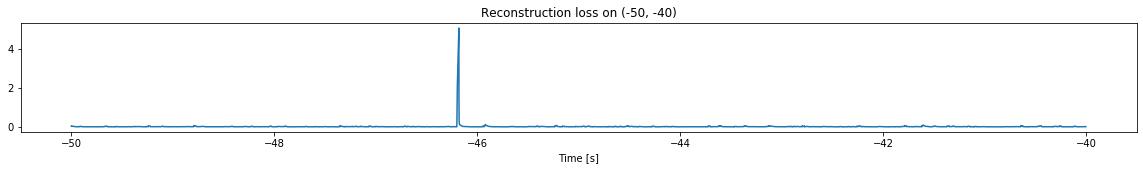

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


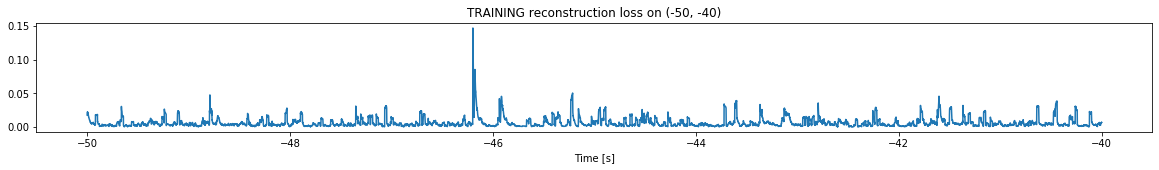

Finished training, median of the log(loss) is:  -2.3474291050185143
Triggering for section:  (-40, -30)
Using this median for triggering: -2.0699974703719457


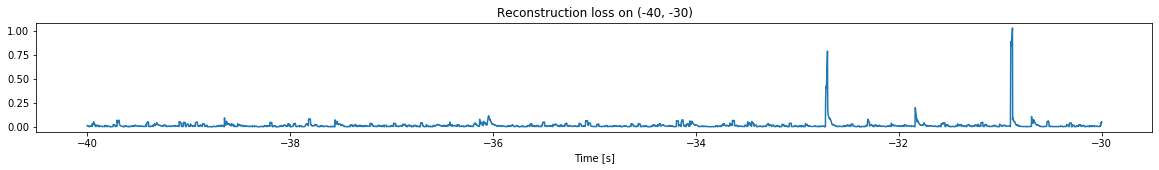

<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


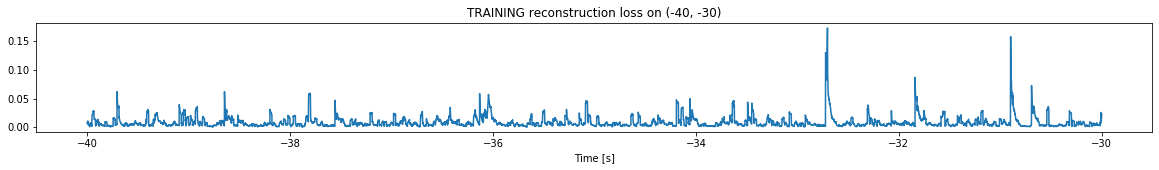

Finished training, median of the log(loss) is:  -2.2332399592218755
Triggering for section:  (-30, -20)
Using this median for triggering: -2.3474291050185143


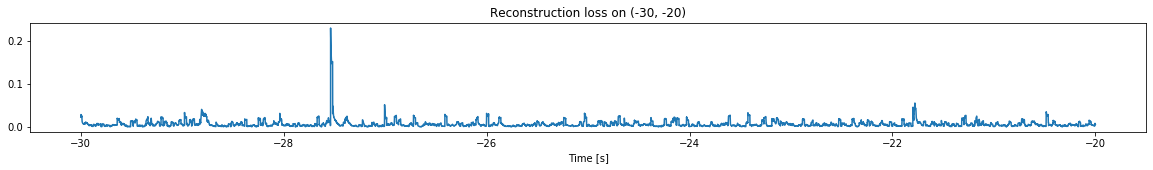

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


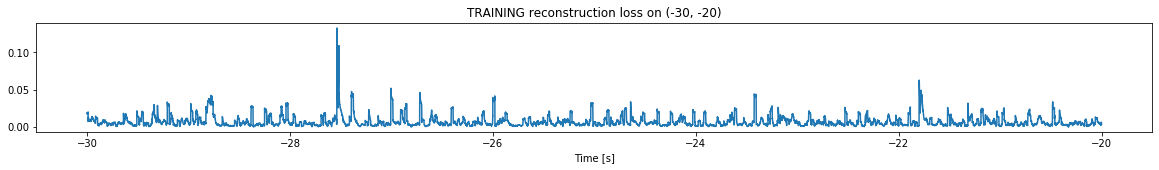

Finished training, median of the log(loss) is:  -2.2615248541431567
Triggering for section:  (-20, -10)
Using this median for triggering: -2.2332399592218755


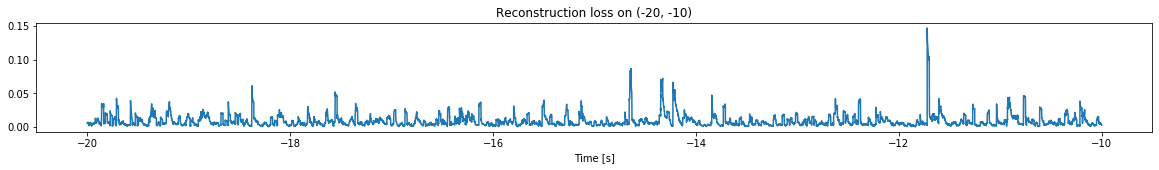

<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


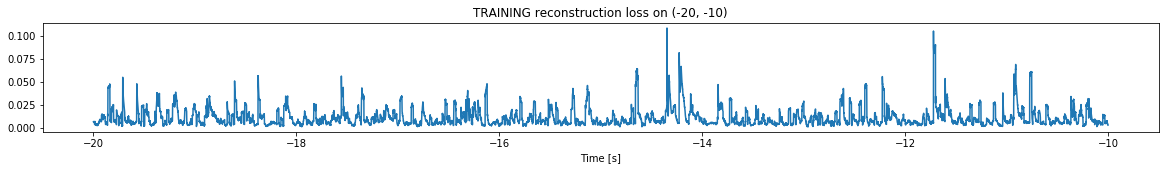

Finished training, median of the log(loss) is:  -2.1069694420267755
Triggering for section:  (-10, 0)
Using this median for triggering: -2.2615248541431567


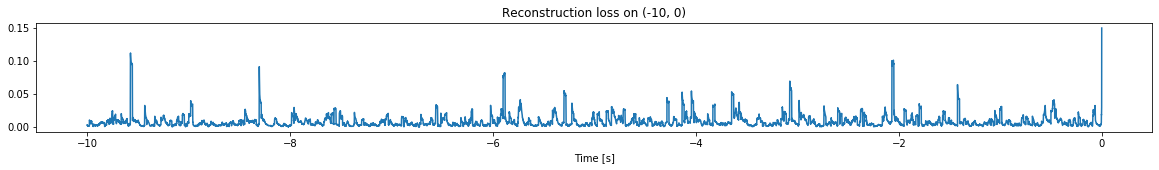

<--------
Finished simulation, all the triggered times are:  [-142.9188, -141.91309, -141.23909, -140.48679, -137.92479, -136.77028, -136.0718, -134.94579, -133.17009, -132.0474, -131.52489, -130.09099]


In [10]:
simulation("./data/Ramp20/", 10, (-212,0))

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
All data's shape:  (1197500, 12)
Flushing input history
Number of sections: 12
Entering sections:  (-120, -110)
-------->
Entering sections:  (-110, -100)
-------->
Training for section:  (None, -110)


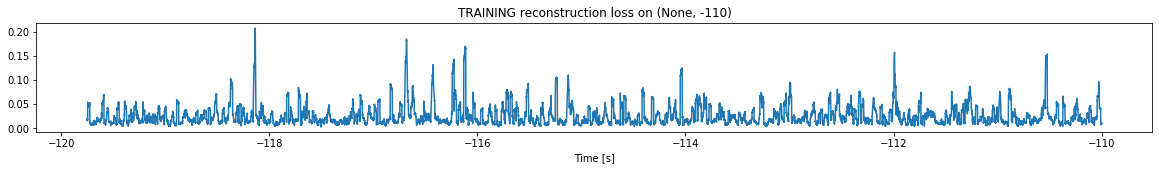

Finished training, median of the log(loss) is:  -1.7077684379327347
<--------
Entering sections:  (-100, -90)
-------->
Training for section:  (-110, -100)


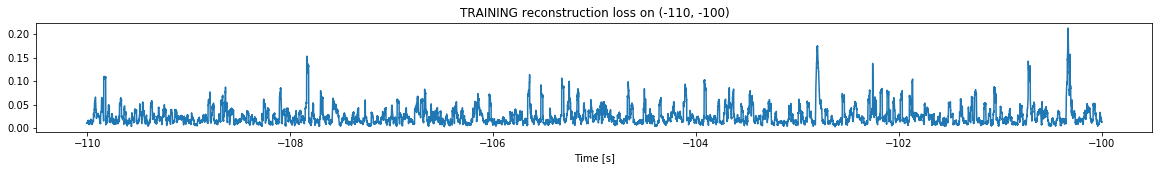

Finished training, median of the log(loss) is:  -1.7015543262392698
Triggering for section:  (-100, -90)
Using this median for triggering: -1.7077684379327347


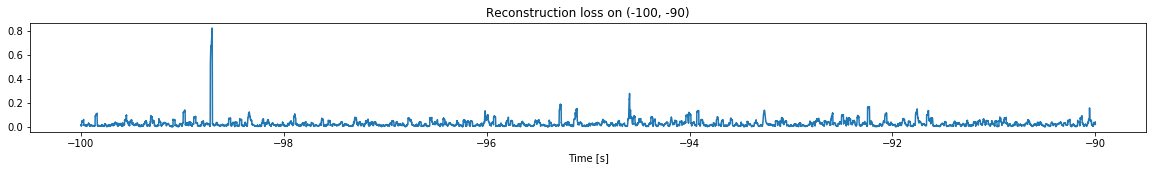

<--------
Entering sections:  (-90, -80)
-------->
Training for section:  (-100, -90)


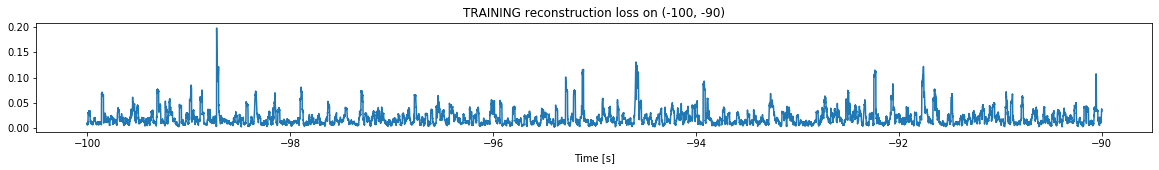

Finished training, median of the log(loss) is:  -1.8033449940505832
Triggering for section:  (-90, -80)
Using this median for triggering: -1.7015543262392698


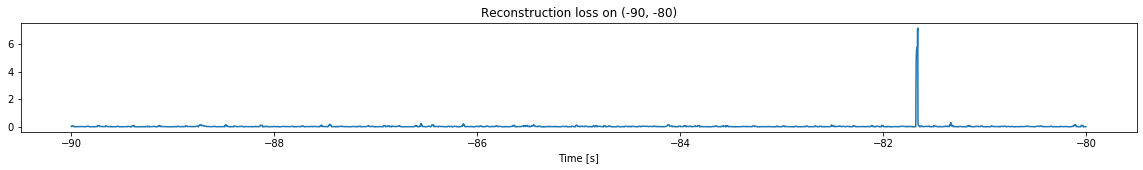

<--------
Entering sections:  (-80, -70)
-------->
Training for section:  (-90, -80)


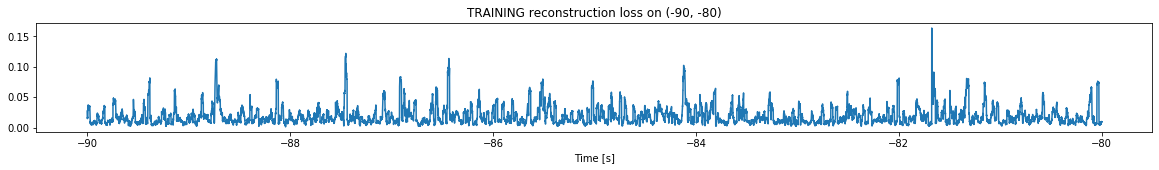

Finished training, median of the log(loss) is:  -1.8333357221048432
Triggering for section:  (-80, -70)
Using this median for triggering: -1.8033449940505832


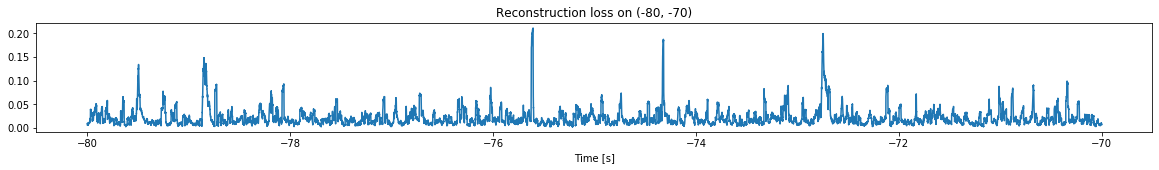

<--------
Entering sections:  (-70, -60)
-------->
Training for section:  (-80, -70)


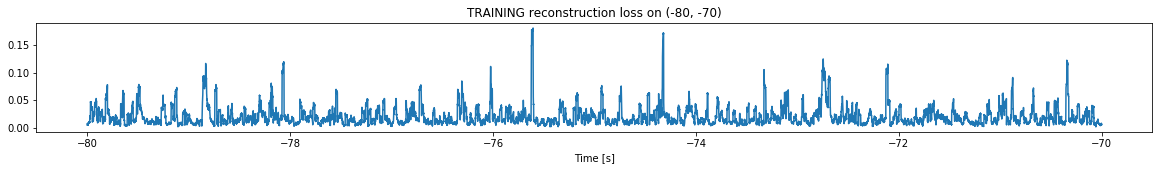

Finished training, median of the log(loss) is:  -1.7992339643540756
Triggering for section:  (-70, -60)
Using this median for triggering: -1.8333357221048432


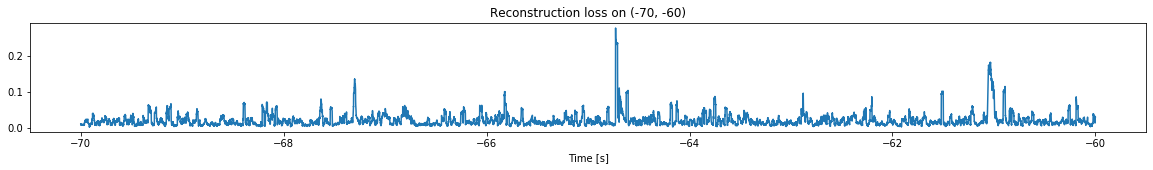

<--------
Entering sections:  (-60, -50)
-------->
Training for section:  (-70, -60)


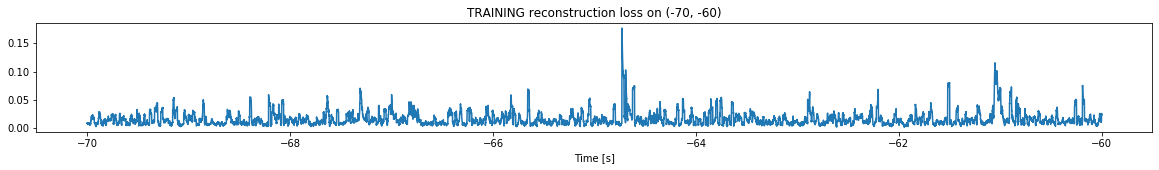

Finished training, median of the log(loss) is:  -1.8957559678523794
Triggering for section:  (-60, -50)
Using this median for triggering: -1.7992339643540756


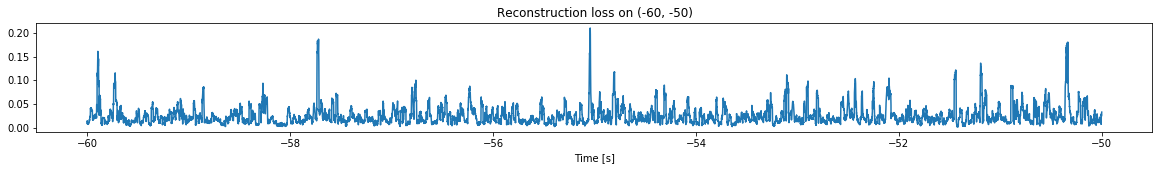

<--------
Entering sections:  (-50, -40)
-------->
Training for section:  (-60, -50)


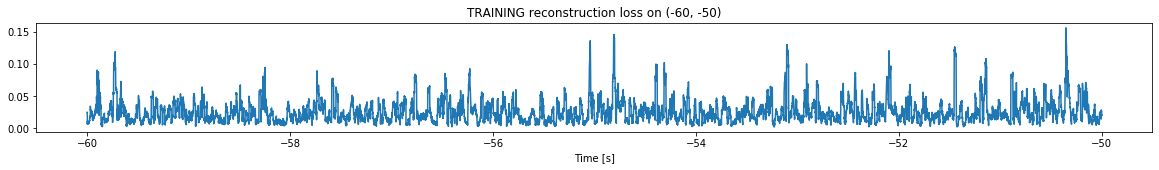

Finished training, median of the log(loss) is:  -1.65139925570312
Triggering for section:  (-50, -40)
Using this median for triggering: -1.8957559678523794


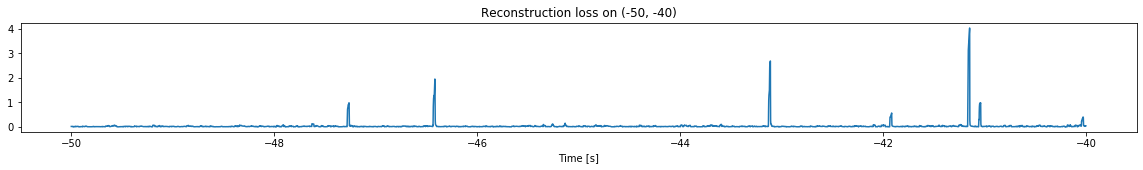

<--------
Entering sections:  (-40, -30)
-------->
Training for section:  (-50, -40)


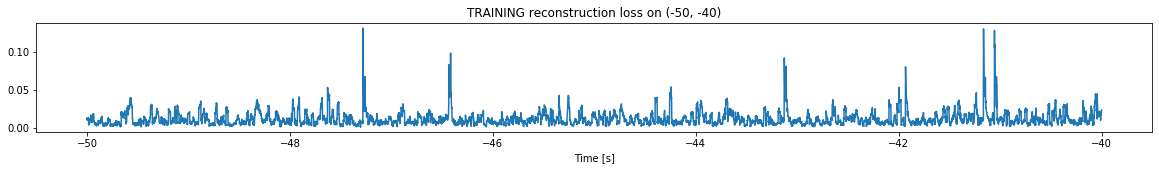

Finished training, median of the log(loss) is:  -2.0104803983848205
Triggering for section:  (-40, -30)
Using this median for triggering: -1.65139925570312


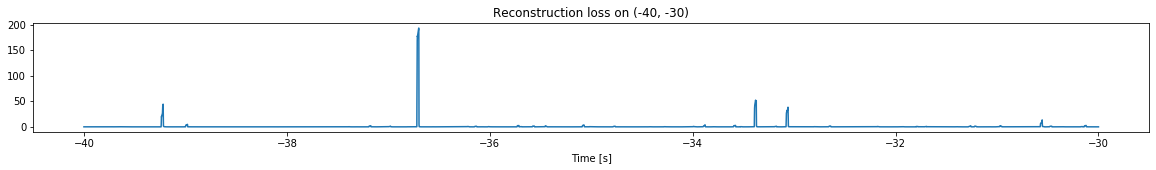

Other trigger time:  [-39.2193   -36.699398 -33.379498]
Their log loss values are:  [1.64828847 2.28730989 1.71939681]


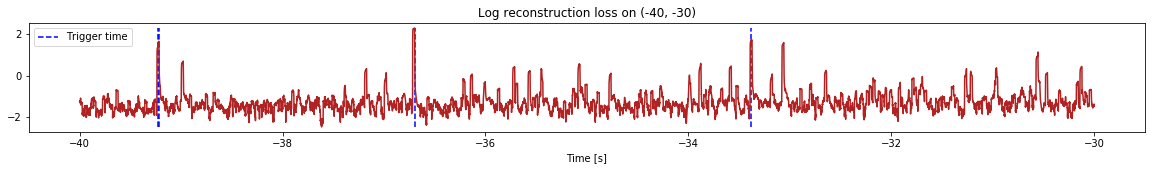

Triggered at:  [-39.2193, -36.699398, -33.379498]
<--------
Entering sections:  (-30, -20)
-------->
Training for section:  (-40, -30)


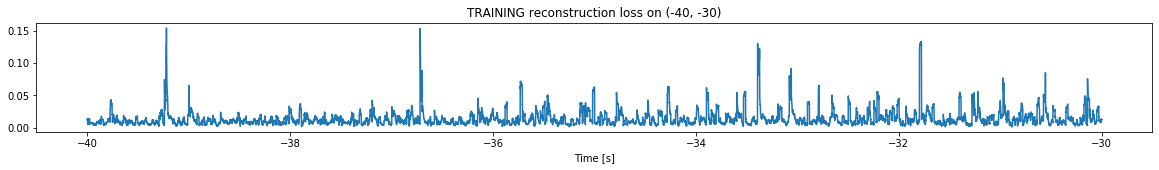

Finished training, median of the log(loss) is:  -1.9641906830778182
Triggering for section:  (-30, -20)
Using this median for triggering: -2.0104803983848205


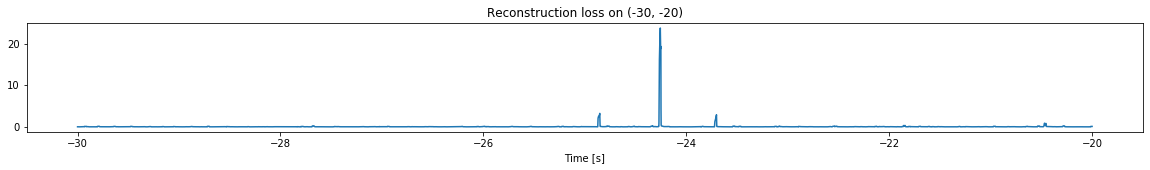

<--------
Entering sections:  (-20, -10)
-------->
Training for section:  (-30, -20)


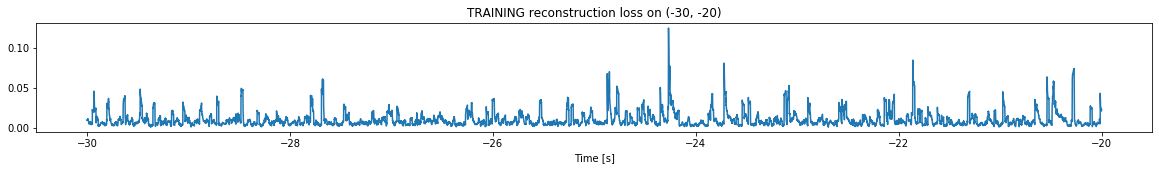

Finished training, median of the log(loss) is:  -2.1323189965533134
Triggering for section:  (-20, -10)
Using this median for triggering: -1.9641906830778182


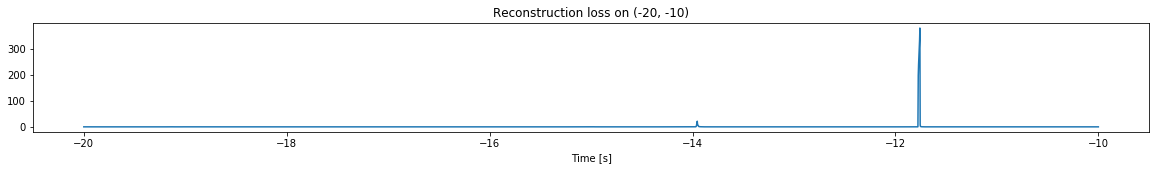

Other trigger time:  [-11.759]
Their log loss values are:  [2.57964661]


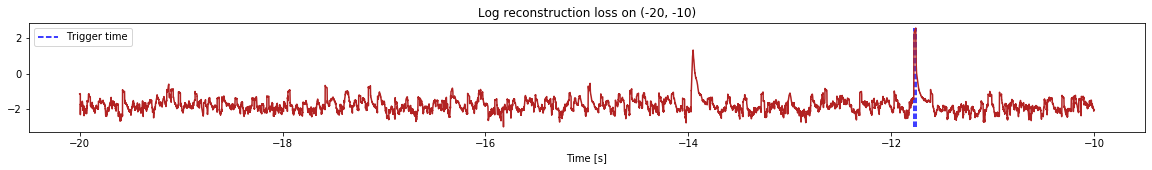

Triggered at:  [-11.759]
<--------
Entering sections:  (-10, 0)
-------->
Training for section:  (-20, -10)


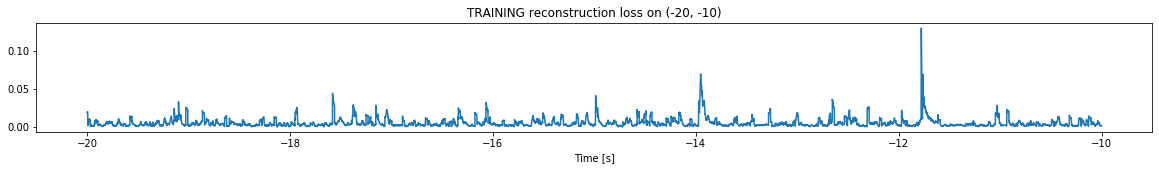

Finished training, median of the log(loss) is:  -2.396795734577343
Triggering for section:  (-10, 0)
Using this median for triggering: -2.1323189965533134


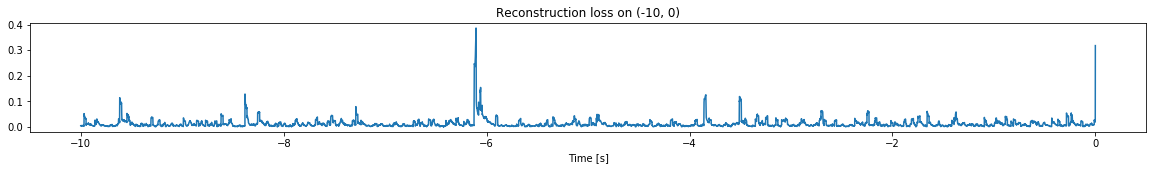

<--------
Finished simulation, all the triggered times are:  [-39.2193, -36.699398, -33.379498, -11.759]


In [11]:
simulation("./data/Ramp21/", 10, (-120,0))

In [12]:
simulation("./data/Ramp22/", 10, (-80,0))

Flushing input history
Flushing input history


KeyboardInterrupt: 

In [ ]:
simulation("./data/Ramp23/", 10, (-50,0))

In [ ]:
simulation("./data/Ramp24/", 10, (-110,0))

In [ ]:
simulation("./data/Ramp25/", 10, (-100,0))

In [ ]:
simulation("./data/Ramp26/", 10, (-110,0))

In [ ]:
simulation("./data/Ramp27/", 10, (-70,0))

In [ ]:
simulation("./data/Ramp28/", 10, (-60,0))

In [ ]:
simulation("./data/Ramp29/", 10, (-100,0))

In [ ]:
simulation("./data/Ramp30/", 10, (-120,0))